In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/Let this be the last time/TrafficEmuTimeloss


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator
from experimental_design import config

sns.set()
LOOPS = 500

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            junctionType  = 2,
            tlType        = 2, 
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
parameter_space = config.get_parameter_space()

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[ 8.         12.50589839 49.46786477  2.          2.50682045]
 [19.          8.08923739 41.33558548  2.          3.02355199]
 [ 8.         11.05168567 57.11202711  3.          4.62601306]
 [ 5.         14.94106694 57.18994805  1.          2.69858576]
 [14.          9.47049436 42.14602363  2.          1.75099698]
 [ 8.         16.48237407 51.10619582  2.          4.96826162]
 [ 4.         12.61105524 58.47413928  1.          4.62292886]
 [18.         13.28202205 68.45652911  1.          2.80032754]
 [11.         15.51140352 53.34274682  2.          2.33782229]
 [10.         11.89607736 68.06465724  1.          3.53701928]
 [15.         12.64934949 48.62039236  3.          1.95367572]
 [13.          8.09136359 43.98310308  2.          3.36513158]
 [14.         10.64822646 49.21494269  3.          4.08770349]
 [13.         17.49111495 61.43025027  3.          3.23689585]
 [17.         16.42714157 46.52048771  1.          1.80082848]
 [20.         17.8996805  55.34618257  3.          1.74

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType        = 2,
            junctionType  = 2,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(s['timeLoss']/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
kg = GPy.kern.RBF(input_dim=5, ARD=True)
emulator_mv = GPy.models.GPRegression(init_X, init_Y, kg, noise_var=1e-4)
emulator_mv.optimize()

emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = -26.908313239954897
Optimization restart 2/5, f = -22.530526955180825
Optimization restart 3/5, f = 16.216625125332108
Optimization restart 4/5, f = 16.216625857333476
Optimization restart 5/5, f = -12.957151827883362


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


GP_regression.,value,constraints,priors
rbf.variance,188977.52311366357,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,0.000737569617603509,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, LOOPS)

Optimization restart 1/5, f = -26.908313239954897
Optimization restart 2/5, f = -33.274080192952056
Optimization restart 3/5, f = -23.299171603909425
Optimization restart 4/5, f = -25.760157688252534
Optimization restart 5/5, f = -29.149267436220384
[[13. 19. 30.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -35.16776793158478
Optimization restart 2/5, f = -27.593074607733726


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -35.16331073122559
Optimization restart 4/5, f = -9.448855125377747
Optimization restart 5/5, f = 17.335861269786676
[[ 7.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -36.61467998897803
Optimization restart 2/5, f = -36.62431762323989
Optimization restart 3/5, f = -8.743190283428968


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -28.87055928604334
Optimization restart 5/5, f = -36.63937616929688
[[ 8.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -38.44183695117729
Optimization restart 2/5, f = 4.697681079203008
Optimization restart 3/5, f = 19.294207566848158
Optimization restart 4/5, f = -34.458191600397384


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -35.417395057504095
[[18.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -38.41054558458825
Optimization restart 2/5, f = 20.021747677374442
Optimization restart 3/5, f = -37.929255270095055
Optimization restart 4/5, f = -38.32221720253072
Optimization restart 5/5, f = 20.021756654615515
[[10.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -40.71900363369829
Optimization restart 2/5, f = -29.774152769568733
Optimization restart 3/5, f = 21.125135296837
Optimization restart 4/5, f = -40.64726609178293
Optimization restart 5/5, f = -40.81315769134426
[[16.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -41.87114019058645
Optimization restart 2/5, f = 21.682214329791222
Optimization restart 3/5, f = -36.38195897462026
Optimization restart 4/5, f = -41.83901454763195
Optimization restart 5/5, f = -21.11027226242434
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -42.397332817606355
Optimization restart 2/5, f = -12.143263754643208
Optimization restart 3/5, f = 22.645363029050074
Optimization restart 4/5, f = -12.674164216501778
Optimization restart 5/5, f = 22.645362998399257
[[20. 19. 70.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -45.84891654412922
Optimization restart 2/5, f = -26.71904045023948
Optimization restart 3/5, f = 23.491909782443926
Optimization restart 4/5, f = -18.130958181311197
Optimization restart 5/5, f = 23.491879967344474
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -48.10920255358862
Optimization restart 2/5, f = 24.87291972701862
Optimization restart 3/5, f = -48.26650984635442


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -45.868085421025285
Optimization restart 5/5, f = -41.98849348470706
[[17. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -50.754744263669245
Optimization restart 2/5, f = -50.75474330318548
Optimization restart 3/5, f = -41.22800087527095
Optimization restart 4/5, f = 25.949292561365944
Optimization restart 5/5, f = -33.28760054674016
[[11.  19.  70.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -53.334770669381996
Optimization restart 2/5, f = -18.51387740790834
Optimization restart 3/5, f = -34.1355019546354
Optimization restart 4/5, f = -35.45266542189151
Optimization restart 5/5, f = -34.16540451960008
[[15.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -36.794068629576884
Optimization restart 2/5, f = -39.05347379786403
Optimization restart 3/5, f = 28.23915730109339
Optimization restart 4/5, f = -39.053474199555296
Optimization restart 5/5, f = -39.0534743469973
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -40.074129111204655
Optimization restart 2/5, f = -11.622625606094925
Optimization restart 3/5, f = -33.6799030993583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -35.12951872563287
Optimization restart 5/5, f = -9.14719152779328
[[ 4.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -41.99798770208248
Optimization restart 2/5, f = -30.40567747422407
Optimization restart 3/5, f = -40.29219085306028
Optimization restart 4/5, f = 30.002726489968197
Optimization restart 5/5, f = -41.99801613301595
[[ 8.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -43.96683387204866
Optimization restart 2/5, f = -38.32708846148461
Optimization restart 3/5, f = 30.828397710693682
Optimization restart 4/5, f = -43.96683210476332
Optimization restart 5/5, f = -43.96683765039718
[[10.          8.         64.99248125  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -43.38595603777786
Optimization restart 2/5, f = 31.433964803391124
Optimization restart 3/5, f = -42.0267403911268


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -42.34032505882247
Optimization restart 5/5, f = -42.026741897289796
[[ 3.         14.86220227 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -43.89966908442676
Optimization restart 2/5, f = -43.42796949034861
Optimization restart 3/5, f = -10.037934476562345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -43.89967003937737
Optimization restart 5/5, f = -42.31845472387126
[[10.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -45.51644328246269
Optimization restart 2/5, f = -45.14365920215403
Optimization restart 3/5, f = -45.14375555783093
Optimization restart 4/5, f = 32.94350121462779
Optimization restart 5/5, f = -45.30750236893948
[[14. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -47.448282273532804
Optimization restart 2/5, f = 33.806659769314095
Optimization restart 3/5, f = -28.49610483555685
Optimization restart 4/5, f = 33.806664240823
Optimization restart 5/5, f = -42.91862012708182
[[14.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -49.37360696610581
Optimization restart 2/5, f = -48.82145668129463


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -42.05231189975714
Optimization restart 4/5, f = -49.041963831582244
Optimization restart 5/5, f = -41.79738138802887
[[17.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -51.336214928668944
Optimization restart 2/5, f = -46.63896782969282
Optimization restart 3/5, f = 36.311759826660285
Optimization restart 4/5, f = -50.73660052951226
Optimization restart 5/5, f = -51.33621140563808
[[ 7.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -53.02007961661191
Optimization restart 2/5, f = -48.70544697803904
Optimization restart 3/5, f = -52.83641646298734
Optimization restart 4/5, f = -52.82236557060064
Optimization restart 5/5, f = -52.836416562312564
[[ 6.         16.18572041 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -55.00645754041469
Optimization restart 2/5, f = -48.40772841744801
Optimization restart 3/5, f = -54.88988617741449
Optimization restart 4/5, f = 37.60659677162
Optimization restart 5/5, f = -54.895247975322896


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[12.         10.19213769 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -57.07254001702574
Optimization restart 2/5, f = -42.92372863977662
Optimization restart 3/5, f = -56.9497776850759
Optimization restart 4/5, f = 38.561706115659504
Optimization restart 5/5, f = -56.858616721572886
[[20.         19.         44.11317447  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -59.08985660431105
Optimization restart 2/5, f = -59.059834625041375
Optimization restart 3/5, f = -59.08985749350528
Optimization restart 4/5, f = -31.316246397574155
Optimization restart 5/5, f = -58.796620017193426
[[20.          8.         58.10105158  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -60.36583803543468
Optimization restart 2/5, f = -60.365856809654865
Optimization restart 3/5, f = -38.26887335306728


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -60.90676598594594
Optimization restart 5/5, f = -53.23271671606007
[[ 6.         19.         30.          2.          3.28084377]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -62.873106919450954
Optimization restart 2/5, f = -62.4068894531832
Optimization restart 3/5, f = -62.87439017752449


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -62.36294907344356
Optimization restart 5/5, f = -62.284569947430576
[[ 9.  8. 30.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -64.55809845250144
Optimization restart 2/5, f = -64.23801338049262
Optimization restart 3/5, f = -64.23801358054928
Optimization restart 4/5, f = 42.2567915633341
Optimization restart 5/5, f = -64.23800182748829
[[13.          8.         30.          3.          3.17862096]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -60.799854348588426
Optimization restart 2/5, f = -63.282356115978324
Optimization restart 3/5, f = -60.85865017933731
Optimization restart 4/5, f = -63.282356201614164
Optimization restart 5/5, f = -63.28235609769578
[[ 3.          8.         41.34338888  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -65.25428394954906
Optimization restart 2/5, f = -65.25434690762152
Optimization restart 3/5, f = -64.12937442314782
Optimization restart 4/5, f = -56.1944236120233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -65.25434695458884
[[ 3.         19.         47.76012953  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -66.70911440942665
Optimization restart 2/5, f = -43.240135618123055


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -54.276050603624434
Optimization restart 4/5, f = -47.729344381682345
Optimization restart 5/5, f = -57.54348146673983
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -68.77345453093096
Optimization restart 2/5, f = -68.77345458817346
Optimization restart 3/5, f = -67.12432270129632


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -68.77345449274648
Optimization restart 5/5, f = 42.515204954958485
[[20.   8.  70.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -70.93588045291798
Optimization restart 2/5, f = -70.93588632120435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -65.06628766949288
Optimization restart 4/5, f = -70.9358864241348
Optimization restart 5/5, f = -70.93588639955209
[[20.        19.        50.3209052  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -73.10043151205718
Optimization restart 2/5, f = -73.1004314820627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -63.04741770389991
Optimization restart 4/5, f = -73.10043153743203
Optimization restart 5/5, f = -71.50782500010291
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -75.26824376519926
Optimization restart 2/5, f = -0.2093352563567592
Optimization restart 3/5, f = -71.85055774104205


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -75.26824400921608
Optimization restart 5/5, f = -75.26824408139022
[[20.          8.         58.94283971  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -77.30376040097524
Optimization restart 2/5, f = -77.30375963040984
Optimization restart 3/5, f = -71.79965625752251
Optimization restart 4/5, f = 43.36956349544955
Optimization restart 5/5, f = -77.30376040490808
[[20.         12.24317145 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -78.70940845593985
Optimization restart 2/5, f = -78.7094084790197
Optimization restart 3/5, f = -78.70940824557407
Optimization restart 4/5, f = -66.56727488179098
Optimization restart 5/5, f = -78.70940847998284
[[ 3.          8.         50.27419364  3.          1.5       ]]

User 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -65.29914190254428
Optimization restart 4/5, f = -63.50343829253661
Optimization restart 5/5, f = -13.174495719174647
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -82.926419658866
Optimization restart 2/5, f = -82.92641964717454
Optimization restart 3/5, f = 0.6441894410258726
Optimization restart 4/5, f = -76.78974255545495
Optimization restart 5/5, f = -52.06826387879259


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -85.1825805886828
Optimization restart 2/5, f = -45.31526102386731


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -85.18348325700742
Optimization restart 4/5, f = -76.6463929154115
Optimization restart 5/5, f = -85.18348289914795
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -84.92226956425074
Optimization restart 2/5, f = -70.42174351639244
Optimization restart 3/5, f = -84.92226956248953
Optimization restart 4/5, f = -84.92226949731423
Optimization restart 5/5, f = -84.92226956014355
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -87.13913234703085
Optimization restart 2/5, f = -12.440882492941796
Optimization restart 3/5, f = -83.0780281576273


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -48.7520307569676
Optimization restart 5/5, f = -87.13955844895065
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -89.26477237804733
Optimization restart 2/5, f = -89.26496599442153
Optimization restart 3/5, f = 55.515284789538725
Optimization restart 4/5, f = -67.40295587013503
Optimization restart 5/5, f = -14.577211549120328
[[14.         13.82273407 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -91.26807772559265
Optimization restart 2/5, f = -91.26823893776124
Optimization restart 3/5, f = -75.86915858522161
Optimization restart 4/5, f = -18.293286439163587
Optimization restart 5/5, f = -82.24104377605019


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         13.44109513 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -93.50024178235269
Optimization restart 2/5, f = -93.50031910977438
Optimization restart 3/5, f = -93.50031900751836
Optimization restart 4/5, f = -93.5003188153809
Optimization restart 5/5, f = -93.50031910505761
[[ 3.         19.         51.30642486  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -95.64777395013617
Optimization restart 2/5, f = -19.787888121935396


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -95.64829261001296
Optimization restart 4/5, f = -78.78795163532243
Optimization restart 5/5, f = -87.67054987636337
[[ 3.         10.52033118 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -97.92317974805533
Optimization restart 2/5, f = -97.92598892002414
Optimization restart 3/5, f = -80.93140865834519
Optimization restart 4/5, f = -97.92598876068686
Optimization restart 5/5, f = -80.93140883303074
[[20.         19.         53.46105877  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -100.23434437022769
Optimization restart 2/5, f = -100.23449486226191
Optimization restart 3/5, f = -84.81517514862401
Optimization restart 4/5, f = -77.55301235127185
Optimization restart 5/5, f = 24.309092549672396
[[ 3.         14.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds
Optimization restart 1/5, f = -102.38291553425675
Optimization restart 2/5, f = -84.38749786898423
Optimization restart 3/5, f = -97.15633404526795
Optimization restart 4/5, f = -84.38749781610187
Optimization restart 5/5, f = -84.38749922308264
[[20.          8.         51.71282066  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 0.026744240584304663
Optimization restart 1/5, f = -104.06652929816048
Optimization restart 2/5, f = -104.06652923996623
Optimization restart 3/5, f = -21.03505781125267
Optimization restart 4/5, f = -55.69652454478195
Optimization restart 5/5, f = 16.11276410712445
[[20.         13.13755735 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds
Optimization restart 1/5, f = -105.28879623059586
Optimization restart 2/5, f = -105.28879617742287
Optimization restart 3/5, f = -105.2887961559633


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -79.75419412983806
Optimization restart 5/5, f = -105.28879623198293
[[ 3.         8.        42.7142314  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -107.5104771026241
Optimization restart 2/5, f = -79.14400413642315


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -107.51047703585107
Optimization restart 4/5, f = -107.51047572568939
Optimization restart 5/5, f = -102.11443800249654


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         14.70249138 30.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -109.799119266679
Optimization restart 2/5, f = -109.79916000405173
Optimization restart 3/5, f = -109.79915983598946
Optimization restart 4/5, f = -109.79916034303392
Optimization restart 5/5, f = -109.7991604027765
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -111.92874334753348
Optimization restart 2/5, f = -91.43310967508052
Optimization restart 3/5, f = 35.116433615376394


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -111.92880023248551
Optimization restart 5/5, f = -111.92880007497905
[[ 3.         19.         51.71029457  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -114.11565188839243
Optimization restart 2/5, f = -108.01571106080013


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -39.15434408370276
Optimization restart 4/5, f = -110.60970802885184


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -114.11642510812565
[[ 6.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -116.29871657898033
Optimization restart 2/5, f = -104.40897637372156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -116.30068697996794
Optimization restart 4/5, f = -6.532720565903659
Optimization restart 5/5, f = -116.30068726672164
[[20.   8.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -117.72049136473495
Optimization restart 2/5, f = -117.72049351505021
Optimization restart 3/5, f = -117.72049356811883
Optimization restart 4/5, f = -117.720493168972
Optimization restart 5/5, f = -117.72049129563904
[[ 3.         13.77180387 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -120.0519803717667
Optimization restart 2/5, f = -120.05211118725674
Optimization restart 3/5, f = -120.05211098866594
Optimization restart 4/5, f = -120.05211106114677
Optimization restart 5/5, f = -120.052111003759
[[ 3.         13.63021608 30.          3.      

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -118.09520840393805
Optimization restart 4/5, f = -13.284785324428846
Optimization restart 5/5, f = -31.90667571588395
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -123.57526216003518
Optimization restart 2/5, f = -90.1392844651289
Optimization restart 3/5, f = -100.44168825217072
Optimization restart 4/5, f = -36.135731227142536


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -123.57528283124142
[[ 3.          8.         34.47461739  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -125.29459558779914
Optimization restart 2/5, f = -109.43335209008112
Optimization restart 3/5, f = -112.55093625238403


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -83.40139502346172
Optimization restart 5/5, f = -102.61298071196182
[[13. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -127.61285740624382
Optimization restart 2/5, f = -127.61297264375867
Optimization restart 3/5, f = -127.6129722962718
Optimization restart 4/5, f = -32.36854593816031


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -94.48521329441243
[[ 3.        19.        45.7116971  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -129.69894578985452
Optimization restart 2/5, f = -94.70350689472889
Optimization restart 3/5, f = -129.70212591239698
Optimization restart 4/5, f = -129.70212661924194
Optimization restart 5/5, f = -105.1451705025851
[[19.          8.         56.46347519  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -132.01978472423698
Optimization restart 2/5, f = -96.24755871278859


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -122.59081266097941


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -126.75652184249364
Optimization restart 5/5, f = -132.01984738750997
[[17.          8.         52.07726243  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -133.34272654631772
Optimization restart 2/5, f = -124.08494799885985
Optimization restart 3/5, f = -130.39485396471815
Optimization restart 4/5, f = -133.34632243378314
Optimization restart 5/5, f = -132.45996915703626
[[20.         19.         41.66340219  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -135.685931531656
Optimization restart 2/5, f = -79.67697266954721


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -120.34108365137809
Optimization restart 4/5, f = -133.22751685046217
Optimization restart 5/5, f = -135.68600567252145
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -137.6521894053813
Optimization restart 2/5, f = -137.65219159568622
Optimization restart 3/5, f = -137.65219148290754
Optimization restart 4/5, f = -137.65219159566715


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -131.66027229783145
[[20.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -139.96500688880155
Optimization restart 2/5, f = -139.9650162702095
Optimization restart 3/5, f = -139.96501676243838
Optimization restart 4/5, f = -61.749692353532744
Optimization restart 5/5, f = -139.9650150113617
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -142.31836271147688
Optimization restart 2/5, f = -123.7982911035671
Optimization restart 3/5, f = -123.79829110878123
Optimization restart 4/5, f = -123.79829086446298
Optimization restart 5/5, f = -123.79829108196867
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -144.3851600

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds
Optimization restart 1/5, f = -172.4280996200575
Optimization restart 2/5, f = -153.6305494018529
Optimization restart 3/5, f = 2.8663417916620695


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -172.4281001073097
Optimization restart 5/5, f = -172.42810010353054
[[ 3.          8.         60.86309356  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -174.87937494769832
Optimization restart 2/5, f = -142.37530825626516
Optimization restart 3/5, f = -155.75245048233666
Optimization restart 4/5, f = -155.7524511059323
Optimization restart 5/5, f = -155.75245113021347
[[ 3.          8.         67.89567455  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -175.4501311255891
Optimization restart 2/5, f = -130.47249890457692
Optimization restart 3/5, f = -149.23447954466872
Optimization restart 4/5, f = -149.23447969847427
Optimization restart 5/5, f = -87.31146567503569
[[20.  8. 30.  1.  5.]]

User function time loss called with

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds
Optimization restart 1/5, f = -193.6990731912769
Optimization restart 2/5, f = -181.40750275282937
Optimization restart 3/5, f = -181.4072730794131
Optimization restart 4/5, f = -181.40750156246872
Optimization restart 5/5, f = -156.5522984235097
[[ 3.          9.57339324 30.15584932  2.          3.28633559]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -195.99732595909705
Optimization restart 2/5, f = -182.814093476146
Optimization restart 3/5, f = -195.9973258437054
Optimization restart 4/5, f = -182.81409366397605
Optimization restart 5/5, f = -182.81334155226918
[[20.         19.         57.32650346  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -198.4897142047174
Optimization restart 2/5, f = -185.15138004994003
Optimization restart 3/5, f = -182.69185

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -164.5559642268729
Optimization restart 4/5, f = -176.686446702177
Optimization restart 5/5, f = -176.68644775252346
[[ 3.         19.         35.29433131  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -217.18863195917066
Optimization restart 2/5, f = -217.1886327960015
Optimization restart 3/5, f = -178.51102767625815
Optimization restart 4/5, f = -146.7597208482616
Optimization restart 5/5, f = -74.612017699363
[[20.          8.         41.64601669  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -218.84669778964687
Optimization restart 2/5, f = -179.83357739635437
Optimization restart 3/5, f = -179.83357745405237
Optimization restart 4/5, f = -179.83345116437738
Optimization restart 5/5, f = -179.83357586085236
[[ 3.         

 Retrying in 1 seconds
Optimization restart 1/5, f = -262.76449471737493
Optimization restart 2/5, f = -199.90777244494348
Optimization restart 3/5, f = -3.2283095151260994
Optimization restart 4/5, f = -199.90778561710692
Optimization restart 5/5, f = -196.6903097757281
[[20.         13.76456726 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -264.99794510626737
Optimization restart 2/5, f = -264.9979449097271
Optimization restart 3/5, f = -264.99794514869984
Optimization restart 4/5, f = -264.9979451465119
Optimization restart 5/5, f = -200.7103426358577
[[ 3.         16.96956835 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -267.31437848831473
Optimization restart 2/5, f = -207.1271137899859
Optimization restart 3/5, f = -207.127

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -218.34874889500037
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -274.28387445471253
Optimization restart 2/5, f = -198.2841456092965
Optimization restart 3/5, f = -105.94869362966048
Optimization restart 4/5, f = -274.28387558481234
Optimization restart 5/5, f = -213.3516376663384
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -275.610355818552
Optimization restart 2/5, f = -201.6590584802895
Optimization restart 3/5, f = -201.65919514885235
Optimization restart 4/5, f = -201.6592352992995
Optimization restart 5/5, f = -201.6581790015765
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -277.9802206017089
Optimiz

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -289.87157836717256


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -274.72275965415247
Optimization restart 3/5, f = -289.87157819949795
Optimization restart 4/5, f = -289.8715783552117
Optimization restart 5/5, f = -208.90021992447913
[[ 3.         11.81846613 53.46479813  3.          4.74879845]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -292.28914679625046
Optimization restart 2/5, f = -84.59684438083752
Optimization restart 3/5, f = -210.519044294886
Optimization restart 4/5, f = -188.8542470618331
Optimization restart 5/5, f = -210.5190450775918
[[ 3.         13.09890315 69.94381988  3.          4.47576662]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -294.4737836560712
Optimization restart 2/5, f = -225.6008797813361
Optimization restart 3/5, f = -189.85698725223185
Optimization restart 4/5, f = -294.4737836356014
Optimization re

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -233.72573399968542
Optimization restart 5/5, f = -245.1657083303899
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -314.14370828218057
Optimization restart 2/5, f = -224.573182057898
Optimization restart 3/5, f = -236.54350083227558
Optimization restart 4/5, f = -238.02539046532667
Optimization restart 5/5, f = -209.56950912670354
[[ 3.          9.55443464 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -316.43590028008157
Optimization restart 2/5, f = -209.78801997441218
Optimization restart 3/5, f = -235.28718391475832
Optimization restart 4/5, f = -235.2871828511107
Optimization restart 5/5, f = -244.05958152409076
[[ 3.         19.         37.98119824  3.          1.5       ]]

User function time loss called

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -239.5575310204447
Optimization restart 4/5, f = -323.4472637278096
Optimization restart 5/5, f = -130.4832297566785
[[17.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -325.7424339101523
Optimization restart 2/5, f = -133.24786161074235
Optimization restart 3/5, f = -250.32631650190123
Optimization restart 4/5, f = -241.83199778999636
Optimization restart 5/5, f = -241.83199768053487
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -328.2802555163422
Optimization restart 2/5, f = -249.77682632272328
Optimization restart 3/5, f = -216.9625725886693
Optimization restart 4/5, f = -249.77682574331564
Optimization restart 5/5, f = -328.280475207662
[[20.         13.81866253 53.35628346  3.          4.81303026]]

User function time 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -310.4756593521246
Optimization restart 4/5, f = -345.19619851357515
Optimization restart 5/5, f = -279.74809385086905
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -347.80919741258566
Optimization restart 2/5, f = -282.73842553459656
Optimization restart 3/5, f = -282.73816675850037
Optimization restart 4/5, f = -347.8096268547754
Optimization restart 5/5, f = -282.738426289499
[[20.         19.         59.65427294  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -350.4398214285359
Optimization restart 2/5, f = -284.9239334338615
Optimization restart 3/5, f = -204.42554256783978


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -350.4398757958768
Optimization restart 5/5, f = -275.4284650812673
[[20.          8.75754685 69.84522397  3.          2.25405016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -353.04597691806714
Optimization restart 2/5, f = -287.9043273585942
Optimization restart 3/5, f = -287.9048999790008
Optimization restart 4/5, f = -287.90489958849685
Optimization restart 5/5, f = -353.04608180083693
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -355.64416804314976
Optimization restart 2/5, f = -295.8496999388483
Optimization restart 3/5, f = -355.644245230835
Optimization restart 4/5, f = -252.42500491440376
Optimization restart 5/5, f = -295.84972909000487
[[ 3.         18.94944173 45.16291659  3.          4.58833451]]

User function time loss called with 1 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -267.4857873247674
Optimization restart 3/5, f = -372.2415082023157
Optimization restart 4/5, f = -310.3388919895357
Optimization restart 5/5, f = -310.3390611147875
[[19.         13.98893054 69.61173979  2.          1.61161809]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -374.7671382925473
Optimization restart 2/5, f = -374.7671393262656
Optimization restart 3/5, f = -374.7671394500094
Optimization restart 4/5, f = -312.91961110766385
Optimization restart 5/5, f = -374.7671395747873
[[ 3.          8.24907226 57.81856077  2.          1.75821764]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -376.49949522683505
Optimization restart 2/5, f = -376.49949488025396
Optimization restart 3/5, f = -314.9145507754696
Optimization restart 4/5, f = -314.9145502288641
Optimization res

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -243.37751856771442
Optimization restart 3/5, f = -329.91349507761083
Optimization restart 4/5, f = -329.9129589448081
Optimization restart 5/5, f = -329.9134951991273
[[20.         19.         50.73147015  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -396.33827008887516
Optimization restart 2/5, f = -332.9701781768446
Optimization restart 3/5, f = -332.9701795145413
Optimization restart 4/5, f = -332.97018064425174


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -312.00716353928897
[[20.         19.         41.94735737  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -399.0168517438512


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -315.48311514417156
Optimization restart 3/5, f = -336.4051525289304
Optimization restart 4/5, f = -399.0172700423473
Optimization restart 5/5, f = -336.4051535717027
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -401.36548438410097
Optimization restart 2/5, f = -344.34975367797097
Optimization restart 3/5, f = -344.34980365521346
Optimization restart 4/5, f = -344.34980082642176
Optimization restart 5/5, f = -401.36552563816696
[[16.         14.29896778 30.49687978  1.          4.98602415]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -403.8061811069766
Optimization restart 2/5, f = -346.5727267869751
Optimization restart 3/5, f = -346.5727266779841
Optimization restart 4/5, f = -346.57272369209034
Optimization restart 5/5, f = -346.57272614777673
[[

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -318.99308170846496
[[11.          8.05339818 69.13845583  2.          1.67025352]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -409.71576677944915
Optimization restart 2/5, f = -349.6076239582733
Optimization restart 3/5, f = -349.6076226601646
Optimization restart 4/5, f = -208.87324247449789
Optimization restart 5/5, f = -349.60762396807763
[[20.         12.69048651 30.39748623  3.          1.82281876]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -412.0156043045629
Optimization restart 2/5, f = -352.21156271474945
Optimization restart 3/5, f = -352.21156235308104
Optimization restart 4/5, f = -352.21156366895764
Optimization restart 5/5, f = -412.0156043905374
[[20.         18.32704192 63.68333617  3.          4.97051   ]]

User function time loss called with 1 inputs 

Optimization restart 2/5, f = -378.6896562483755
Optimization restart 3/5, f = -360.52687185755013
Optimization restart 4/5, f = -378.68962383450724
Optimization restart 5/5, f = -229.8462881239838
[[20.         15.85354949 68.57207752  3.          1.65985802]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -452.06192309111003
Optimization restart 2/5, f = -381.4442489825574
Optimization restart 3/5, f = -381.444249011087
Optimization restart 4/5, f = -381.4442492821379
Optimization restart 5/5, f = -445.2133791673393
[[ 4.         10.39929732 69.93313628  1.          4.68075857]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -454.08588882902706
Optimization restart 2/5, f = -383.93454649799196
Optimization restart 3/5, f = -383.9345465720053
Optimization restart 4/5, f = -383.9345399926293
Optimization re

Optimization restart 2/5, f = -441.27149273040027
Optimization restart 3/5, f = -441.27149205003457
Optimization restart 4/5, f = -441.27149389695694
Optimization restart 5/5, f = -220.79888707263302
[[20.          8.97004948 60.91502342  1.          1.54052276]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -500.8612990472685
Optimization restart 2/5, f = -443.46738944246715
Optimization restart 3/5, f = -500.86132436607465
Optimization restart 4/5, f = -443.46730389705203


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -241.0829413746324
[[20.         11.22473444 41.27872473  3.          4.93039274]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -503.1807904826178
Optimization restart 2/5, f = -442.46153608490795
Optimization restart 3/5, f = -279.5032779197405
Optimization restart 4/5, f = -442.4615366683255
Optimization restart 5/5, f = -279.5032729783973
[[ 3.         18.24512846 30.71547424  1.          4.95587892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -501.9643626222822
Optimization restart 2/5, f = -435.20071202936526
Optimization restart 3/5, f = -435.2007132821652
Optimization restart 4/5, f = -439.13435082805086
Optimization restart 5/5, f = -274.844264118585
[[20.         15.85019    69.87193797  3.          1.59672935]]

User function time loss called with 1 inputs to si

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -370.6593759177081
Optimization restart 3/5, f = -460.958071766966
Optimization restart 4/5, f = -460.95537215299004
Optimization restart 5/5, f = -460.958074910198
[[20.         10.46828691 40.64322177  3.          1.50724413]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -539.3538688238316
Optimization restart 2/5, f = -446.4335423699529
Optimization restart 3/5, f = -460.70028771178534
Optimization restart 4/5, f = -446.43387750760934
Optimization restart 5/5, f = -460.7000873706237
[[11.         15.58901004 69.14104024  1.          4.6040273 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -542.0535057890061
Optimization restart 2/5, f = -462.2626892449744
Optimization restart 3/5, f = -542.0538663212164
Optimization restart 4/5, f = -387.45184052177086
Optimization rest

 Retrying in 1 seconds
Optimization restart 1/5, f = -576.5595610816695
Optimization restart 2/5, f = -485.0502684710947
Optimization restart 3/5, f = -576.56014393195
Optimization restart 4/5, f = -576.5601453538237
Optimization restart 5/5, f = -485.0503682376451
[[20.          8.         60.91973779  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -579.236923991574
Optimization restart 2/5, f = -487.41525163195683
Optimization restart 3/5, f = -487.4165530853958
Optimization restart 4/5, f = -579.2370422509168
Optimization restart 5/5, f = -487.416554267496
[[20.          8.4462381  66.66951689  3.          4.97797883]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -581.8845380654201
Optimization restart 2/5, f = -489.977753873167
Optimization restart 3/5, f = -489.9777413109091


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -476.32771705540216
[[20.         12.67897175 30.00129335  3.          4.42644979]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -596.1211983929309
Optimization restart 2/5, f = -509.11990605839173
Optimization restart 3/5, f = -596.121117419289
Optimization restart 4/5, f = -509.1199077084501
Optimization restart 5/5, f = -509.11990815067986
[[ 3.         11.86301494 41.75285362  1.          4.90152981]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -598.7000513262317
Optimization restart 2/5, f = -507.0803829076528
Optimization restart 3/5, f = -507.0803888739603
Optimization restart 4/5, f = -507.08038729445195
Optimization restart 5/5, f = -507.08038829437965
[[11.         18.94809876 52.76499605  3.          4.99786061]]

User function time loss called with 1 inputs to 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -494.9988165753011
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -612.8268595909028
Optimization restart 2/5, f = -342.45329475868124
Optimization restart 3/5, f = -527.7078526006094
Optimization restart 4/5, f = -527.707401546309
Optimization restart 5/5, f = -435.6590550800162
[[20.         13.70254204 54.5458163   1.          1.53574522]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -615.5419888015757
Optimization restart 2/5, f = -276.0321136229794
Optimization restart 3/5, f = -530.0815400950537
Optimization restart 4/5, f = -530.0815412503273
Optimization restart 5/5, f = -530.0815399571745
[[20.          9.14268228 30.01732791  3.          4.41793128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retryin

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -612.0870376431521
Optimization restart 5/5, f = -532.0908981494447
[[ 3.         15.88053444 30.6890591   3.          1.57207892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -621.902144738586
Optimization restart 2/5, f = -432.36644088997673
Optimization restart 3/5, f = -529.0055778509739
Optimization restart 4/5, f = -529.0055726399503
Optimization restart 5/5, f = -529.0055782904868
[[20.         10.8706713  69.45492659  2.          1.77271189]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -624.3522711261712
Optimization restart 2/5, f = -434.000219601633
Optimization restart 3/5, f = -529.6720709741669
Optimization restart 4/5, f = -529.67206903243
Optimization restart 5/5, f = -529.6720703584216
[[20.         16.32642139 30.67681463  3.          4.8388766 ]]

User f

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -521.1296661090125
Optimization restart 3/5, f = -549.840035501958
Optimization restart 4/5, f = -549.840036000822
Optimization restart 5/5, f = -549.8400274623295
[[20.         11.65874809 30.52123817  1.          1.7306977 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -649.2682209040408
Optimization restart 2/5, f = -552.9020961549157
Optimization restart 3/5, f = -552.9069520757967
Optimization restart 4/5, f = -552.9069539031534
Optimization restart 5/5, f = -649.2682177061324
[[13.         15.80453819 69.07746649  1.          1.53187402]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -651.9802447101099
Optimization restart 2/5, f = -555.2729242118344
Optimization restart 3/5, f = -555.2729239434823
Optimization restart 4/5, f = -555.2729245541937
Optimization restart 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -541.4770330285692
[[ 3.         15.46163817 50.27930658  1.          4.95550814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -688.7768944193632
Optimization restart 2/5, f = -354.41055044703785
Optimization restart 3/5, f = -583.6424273385281
Optimization restart 4/5, f = -583.6424278034202
Optimization restart 5/5, f = -688.7769184210895
[[ 3.         14.10746965 59.41943036  3.          4.91861499]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -691.1670218449269
Optimization restart 2/5, f = -582.571002958734
Optimization restart 3/5, f = -582.5710010026141
Optimization restart 4/5, f = -582.5709988252546
Optimization restart 5/5, f = -691.1670066910017
[[20.         16.44257146 30.69742904  1.          1.77507942]]

User function time loss called with 1 inputs to simu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -337.16674556575305
[[ 3.         19.         54.81046483  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -703.8363332713562
Optimization restart 2/5, f = -703.8364361367633
Optimization restart 3/5, f = -594.8866158976178
Optimization restart 4/5, f = -594.8863439901097
Optimization restart 5/5, f = -594.8866113096921
[[20.          8.         43.97803502  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -705.6921151027868
Optimization restart 2/5, f = -705.6925917298595
Optimization restart 3/5, f = -705.6925935573443
Optimization restart 4/5, f = -594.7544096170213
Optimization restart 5/5, f = -705.6925935575739
[[20.         14.40747195 48.40637727  3.          1.55519808]]

User function time loss called with 1 inputs to sim

 Retrying in 1 seconds
Optimization restart 1/5, f = -752.2890429754418
Optimization restart 2/5, f = -650.539411875702
Optimization restart 3/5, f = -650.5394150231862
Optimization restart 4/5, f = -752.2890711022403
Optimization restart 5/5, f = -650.5394085414703
[[ 4.        19.        31.0764218  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 0.025432524723448362
Optimization restart 1/5, f = -753.6587241513009
Optimization restart 2/5, f = -615.1708402165641
Optimization restart 3/5, f = -753.6587241385412
Optimization restart 4/5, f = -615.1708429690862
Optimization restart 5/5, f = -615.1708434035329
[[ 4.         16.05063688 69.3542768   1.          4.98984335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -755.6233194871979
Optimization restart 2/5, f = -617.7926307112671
Optimization r

 Retrying in 1 seconds
Optimization restart 1/5, f = -797.1545223549967
Optimization restart 2/5, f = -645.7205307038222
Optimization restart 3/5, f = -645.7205303610318
Optimization restart 4/5, f = -645.7205310679993
Optimization restart 5/5, f = -645.7205282131976
[[11.         16.02884806 69.70369649  2.          4.91354674]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -799.917452833546
Optimization restart 2/5, f = -799.9174617861155
Optimization restart 3/5, f = -648.3660527206096
Optimization restart 4/5, f = -799.9176038451986
Optimization restart 5/5, f = -648.366052766408
[[ 3.         11.11683234 30.10841457  1.          4.38554605]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -802.3647773090008
Optimization restart 2/5, f = -650.6906685722339
Optimization restart 3/5, f = -650.690666711320

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -816.9099464687554
[[20.         10.46058017 44.60296571  1.          4.9040385 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -821.1231660531175
Optimization restart 2/5, f = -665.5703924538872
Optimization restart 3/5, f = -665.569201798618


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -643.2881823328321
Optimization restart 5/5, f = -821.1232465130353
[[ 3.         16.05119917 69.9521902   1.          1.56309372]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -823.7549908079803
Optimization restart 2/5, f = -667.7354885366061
Optimization restart 3/5, f = -823.7554350487924
Optimization restart 4/5, f = -823.7554376608762
Optimization restart 5/5, f = -667.7355271066772
[[20.         19.         64.94876564  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -826.4475575109454
Optimization restart 2/5, f = -552.6147128607229
Optimization restart 3/5, f = -552.6147021031697
Optimization restart 4/5, f = -670.2533630442804
Optimization restart 5/5, f = -670.253365253004
[[ 3.         16.96149698 69.82294285  3.          4.80908015]]

User

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -811.0019491799741
Optimization restart 3/5, f = -680.0499329748252
Optimization restart 4/5, f = -680.049926352891


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -569.810710042316
[[11.          8.16499944 61.2774619   3.          4.99450857]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -850.3466344150002
Optimization restart 2/5, f = -682.1213745804869
Optimization restart 3/5, f = -850.3466679491667
Optimization restart 4/5, f = -567.0530223409211
Optimization restart 5/5, f = -850.3465969315472
[[20.         18.73694908 46.20690351  3.          1.5117593 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -853.0667852855735
Optimization restart 2/5, f = -685.3326539555748
Optimization restart 3/5, f = -853.0668530643727
Optimization restart 4/5, f = -685.332656701842
Optimization restart 5/5, f = -839.4241983413588
[[ 3.         17.5604996  30.13497818  1.          4.91553106]]

User function time loss called with 1 inputs to simula

Optimization restart 2/5, f = -900.9484861136143
Optimization restart 3/5, f = -899.963707151763
Optimization restart 4/5, f = -899.9637100600091
Optimization restart 5/5, f = -678.6493142145987
[[20.         12.17359434 30.24619044  3.          4.9522056 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -901.9556471856445
Optimization restart 2/5, f = -680.7292944660221
Optimization restart 3/5, f = -900.534692230179
Optimization restart 4/5, f = -680.7293087701707
Optimization restart 5/5, f = -420.0551334214715
[[20.         15.1783217  30.46235619  1.          4.89647179]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -904.7436547996789
Optimization restart 2/5, f = -692.6982995889595
Optimization restart 3/5, f = -673.1392042953589
Optimization restart 4/5, f = -870.0423565841156
Optimization restart 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -604.0279486439424
Optimization restart 3/5, f = -923.6187577965992
Optimization restart 4/5, f = -694.2778760657641
Optimization restart 5/5, f = -694.2778761442914
[[ 3.         10.99109532 30.29978511  3.          1.80653283]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -926.4182563200229
Optimization restart 2/5, f = -692.6632467796443
Optimization restart 3/5, f = -692.663314782011
Optimization restart 4/5, f = -692.6633082033132
Optimization restart 5/5, f = -692.6633141935872
[[20.         18.90914459 45.14718055  3.          1.61784433]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -929.1727710895739
Optimization restart 2/5, f = -695.7436705128735
Optimization restart 3/5, f = -695.7436727594916
Optimization restart 4/5, f = -695.7436698747118
Optimization restart

 Retrying in 1 seconds
Optimization restart 1/5, f = -973.1181652752985
Optimization restart 2/5, f = -716.6460525567669
Optimization restart 3/5, f = -972.2622639992123
Optimization restart 4/5, f = -972.2622606571656
Optimization restart 5/5, f = -716.6460528551829
[[ 3.         19.         60.45534931  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -975.9081511193563
Optimization restart 2/5, f = -599.5465792299083
Optimization restart 3/5, f = -420.064959786924
Optimization restart 4/5, f = -461.8739864408311
Optimization restart 5/5, f = -719.5575639087475
[[ 3.         18.79030737 38.16755735  1.          4.94240258]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -978.434660427152
Optimization restart 2/5, f = -977.169546320175
Optimization restart 3/5, f = -978.4346872990635

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -711.8726451702295
Optimization restart 5/5, f = -781.4456019704021
[[20.         18.88299318 36.63695927  3.          4.86195317]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1010.737223799783
Optimization restart 2/5, f = -1009.3630309259981
Optimization restart 3/5, f = -997.5968749542913
Optimization restart 4/5, f = -621.0424199684846
Optimization restart 5/5, f = -744.3527779443496
[[ 9.         19.         69.45908937  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1013.533651271729
Optimization restart 2/5, f = -600.9099704805308
Optimization restart 3/5, f = -727.3530333164001
Optimization restart 4/5, f = -749.1850312354395
Optimization restart 5/5, f = -749.1850308198071
[[ 3.         15.96660453 47.28585586  1.          1.5291757 ]]

Us

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -462.7547784466646
Optimization restart 3/5, f = -1045.1797381251904
Optimization restart 4/5, f = -689.5872620040689
Optimization restart 5/5, f = -1045.1797674957938
[[10.          8.09006989 69.76175362  2.          1.5992318 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1047.8442495896938
Optimization restart 2/5, f = -1047.8443481338468
Optimization restart 3/5, f = -1047.8443492762024
Optimization restart 4/5, f = -666.118771097374
Optimization restart 5/5, f = -666.1187712103917
[[ 3.         16.78645987 39.03380933  3.          4.6457811 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1049.002256013644
Optimization restart 2/5, f = -1049.002555674456
Optimization restart 3/5, f = -1049.0025603594179
Optimization restart 4/5, f = -667.7393737262923
Optimization r

 Retrying in 1 seconds
Optimization restart 1/5, f = -1090.7786675563516
Optimization restart 2/5, f = -1090.7787405160286
Optimization restart 3/5, f = -1090.7787374764782
Optimization restart 4/5, f = -1090.778743055807
Optimization restart 5/5, f = -703.494227318982
[[ 3.         14.04989815 69.50473926  2.          4.9873735 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1093.5338382747
Optimization restart 2/5, f = -710.6597663478954
Optimization restart 3/5, f = -1093.533862003518
Optimization restart 4/5, f = -1093.5338594473958
Optimization restart 5/5, f = -15.059514954071403
[[20.          8.         46.28236817  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 0.02517787883532428
Optimization restart 1/5, f = -1095.6069464173524
Optimization restart 2/5, f = -712.5457538315802
Optimi

### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType        = 2,
            junctionType  = 2,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(s['timeLoss']/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
kg = GPy.kern.RBF(input_dim=5, ARD=True)
emulator_ivr = GPy.models.GPRegression(init_X, init_Y, kg, noise_var=1e-4)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = -26.90831318512537
Optimization restart 2/5, f = -25.354241880977145


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -25.76015525241796
Optimization restart 4/5, f = 16.216625712642124
Optimization restart 5/5, f = -28.43664040608178


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=200
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1,
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, LOOPS)

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -30.446812357512314
Optimization restart 2/5, f = -23.81780297464693
Optimization restart 3/5, f = -33.27459155866774
Optimization restart 4/5, f = -33.27445294463394
Optimization restart 5/5, f = 16.21662585733347
[[12.         18.35825128 30.49992816  3.          4.58738939]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -34.8233397675471
Optimization restart 2/5, f = -27.40857600749541


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -27.114153490648622
Optimization restart 4/5, f = 17.366519930437434
Optimization restart 5/5, f = 17.366531992489804
[[ 4.         15.7110623  31.09729577  2.          1.64856892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -36.82946181499574
Optimization restart 2/5, f = -15.489238313882192


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -31.10825059519626
Optimization restart 4/5, f = -19.68218275161741
Optimization restart 5/5, f = 18.5982360078684
[[17.          9.582316   69.3250435   3.          1.64305365]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -39.27777606265748
Optimization restart 2/5, f = 19.226080635389707
Optimization restart 3/5, f = -28.67505263694909
Optimization restart 4/5, f = -4.263906862505024


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 19.226051358651134
[[16.         10.59911286 31.61136425  2.          4.95039144]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -35.29988162585916
Optimization restart 2/5, f = -35.30660630697427
Optimization restart 3/5, f = 20.15822425035391


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -34.315347755656404
Optimization restart 5/5, f = 20.15823169706225
[[14.         18.58861706 31.03249602  3.          4.64355105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -37.47278611771638
Optimization restart 2/5, f = -38.409543360419725
Optimization restart 3/5, f = 21.272890843870563
Optimization restart 4/5, f = -32.9777574393344
Optimization restart 5/5, f = -25.030660256365987
[[11.         17.97355849 69.61765019  3.          2.12708335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -40.53562439646015
Optimization restart 2/5, f = -36.858343212297484
Optimization restart 3/5, f = -36.858343203498876
Optimization restart 4/5, f = -36.85834321426445


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -32.2050244992644
[[19.         11.28775647 30.55590695  3.          1.90383767]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -42.190388658295475
Optimization restart 2/5, f = -42.19039056883712
Optimization restart 3/5, f = -37.44476977304737
Optimization restart 4/5, f = -37.444769773495366
Optimization restart 5/5, f = -40.19846396253428


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.          8.07137679 62.26483976  1.          3.14344571]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -42.317702833370774
Optimization restart 2/5, f = -38.44187983028552
Optimization restart 3/5, f = -30.541143438848845


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -26.059626677261626
Optimization restart 5/5, f = 24.05520729803009
[[10.         18.53069151 41.75674823  1.          4.40031037]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -44.73936141692531
Optimization restart 2/5, f = 25.01985726895049
Optimization restart 3/5, f = -40.40675860742071
Optimization restart 4/5, f = 25.019857268946957
Optimization restart 5/5, f = -37.16452866928579
[[18.         18.91876202 69.14323901  3.          4.69449933]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -47.033923115822674
Optimization restart 2/5, f = -38.947514844771256
Optimization restart 3/5, f = 25.888031361926473
Optimization restart 4/5, f = 25.887975321125587
Optimization restart 5/5, f = 25.8880313405747
[[ 7.         17.75398056 38.83393042  2.          1.60304706]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -49.17892113636965
Optimization restart 2/5, f = -38.13818846829217
Optimization restart 3/5, f = -24.422861575699045


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -49.153518306088856
Optimization restart 5/5, f = -49.17032462276066
[[ 5.          8.77370164 66.0111366   3.          4.99198524]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -51.572383409295774
Optimization restart 2/5, f = -27.64343296934518
Optimization restart 3/5, f = 27.671778801129697
Optimization restart 4/5, f = 27.67180115462746
Optimization restart 5/5, f = -18.361092027814124
[[ 9.         15.38904372 40.96369261  3.          4.92114935]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -53.41719705609608
Optimization restart 2/5, f = 26.714301291736447
Optimization restart 3/5, f = 28.608761240526796
Optimization restart 4/5, f = 28.608757569193013
Optimization restart 5/5, f = 28.608742454124712
[[19.         16.95130783 30.44460118  1.          4.39288866]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -55.913611418608696
Optimization restart 2/5, f = 29.692363078675204
Optimization restart 3/5, f = 29.692349682525464
Optimization restart 4/5, f = -5.387798698887417
Optimization restart 5/5, f = -49.069871647345785
[[13.          8.10461892 30.23150122  3.          1.50942131]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -57.690933179319345
Optimization restart 2/5, f = 10.231585747466184
Optimization restart 3/5, f = -57.69090276408195
Optimization restart 4/5, f = -52.395557718217106
Optimization restart 5/5, f = 30.804653471586686
[[11.          9.62068295 57.97420479  3.          1.50634693]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -60.29625549497092
Optimization restart 2/5, f = -59.23872963994464


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -49.66756910930319
Optimization restart 4/5, f = 31.51007260433054
Optimization restart 5/5, f = -57.949713367312135
[[ 3.          8.05651701 51.69499154  1.          4.9620983 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -58.62110361982588
Optimization restart 2/5, f = -32.15497833606394
Optimization restart 3/5, f = -54.546357791496376
Optimization restart 4/5, f = -51.23953848067325
Optimization restart 5/5, f = 32.138158712631906
[[16.         18.95581311 69.11685032  2.          1.78037158]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -60.88526330550374
Optimization restart 2/5, f = -61.91806812415864
Optimization restart 3/5, f = 33.20072628647198
Optimization restart 4/5, f = 33.20073530587268
Optimization restart 5/5, f = 33.20068131817433
[[ 4.         12.59456729 30.00949925  2.          3.43825395]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -63.94128331156903


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -58.05766551085003
Optimization restart 3/5, f = -58.72478661220208
Optimization restart 4/5, f = -44.18107085421143


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -36.43840979858521
[[17.         18.61220712 31.10977305  1.          2.94047291]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -66.46743758673315
Optimization restart 2/5, f = -66.46941891607123
Optimization restart 3/5, f = -61.20505180789308
Optimization restart 4/5, f = -64.68664959662414
Optimization restart 5/5, f = -66.46941930395181
[[18.         18.31292148 42.62924875  1.          3.34677079]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -68.51757185921262
Optimization restart 2/5, f = -67.17439871787633
Optimization restart 3/5, f = 7.406563813369441
Optimization restart 4/5, f = -62.392460021529025


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -67.17439932667091
[[ 6.         18.31861489 69.10922832  2.          3.38051302]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -70.59694815509518
Optimization restart 2/5, f = -69.08531024858142
Optimization restart 3/5, f = 37.26060860389585
Optimization restart 4/5, f = -70.68778020335478
Optimization restart 5/5, f = -60.00892659369325


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 3.          8.05511915 36.88953862  3.          3.27825692]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -73.22533261907856
Optimization restart 2/5, f = -62.502061208967646
Optimization restart 3/5, f = 38.013427439961404
Optimization restart 4/5, f = -57.73323222859872
Optimization restart 5/5, f = -71.2806851737913
[[ 5.          8.34987601 68.00681717  2.          1.511834  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -75.51840475242054
Optimization restart 2/5, f = 38.61813986946943
Optimization restart 3/5, f = -66.32370115509696
Optimization restart 4/5, f = -58.17255341376831


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -64.6752628743221
[[20.         16.53901131 55.59870729  2.          3.99534278]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -78.25140726083393
Optimization restart 2/5, f = -65.18995719954393
Optimization restart 3/5, f = 39.46048685645928
Optimization restart 4/5, f = -67.30042263740187
Optimization restart 5/5, f = 39.460486856408295


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[20.          8.76706664 40.96899265  3.          4.87469439]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -75.16229193496538
Optimization restart 2/5, f = 40.34007397849276
Optimization restart 3/5, f = 40.340046532927005
Optimization restart 4/5, f = -63.06303711179886
Optimization restart 5/5, f = -75.16229150610657
[[ 3.          8.10598551 31.49824693  2.          3.48448537]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -77.41540215409523
Optimization restart 2/5, f = -77.36815201325199
Optimization restart 3/5, f = 41.117745055845305
Optimization restart 4/5, f = 41.11778479707013
Optimization restart 5/5, f = -70.05440574414965


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 3.          8.25369043 66.66969988  1.          2.95789057]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -79.60435112585915
Optimization restart 2/5, f = -79.59428595273573
Optimization restart 3/5, f = 41.635997557299845
Optimization restart 4/5, f = -79.59114517193998
Optimization restart 5/5, f = -34.80877695846779


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         16.10405363 31.09348816  3.          2.88546337]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -81.77495943416963
Optimization restart 2/5, f = -66.00359763913119
Optimization restart 3/5, f = -61.19831594122162
Optimization restart 4/5, f = -61.198315406567794
Optimization restart 5/5, f = 42.81952965490355
[[ 3.         18.87101082 50.76144402  1.          3.42601522]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -84.18255941950106


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -80.44172202097025
Optimization restart 3/5, f = 1.1686084357875615
Optimization restart 4/5, f = -64.62462688322793
Optimization restart 5/5, f = 43.71413489965491
[[20.          8.88035104 65.15376671  3.          4.91636061]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -86.65205068848769
Optimization restart 2/5, f = -86.81007664461798


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -87.09522296086081
Optimization restart 4/5, f = -86.74113841016165
Optimization restart 5/5, f = -86.66536715816528
[[20.          8.98915057 31.67237492  1.          1.79483487]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -87.85515587963653
Optimization restart 2/5, f = -53.77248255355088


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -84.58363791910297
Optimization restart 4/5, f = -77.76393181403635


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -67.10619081257387
[[ 5.         12.70181348 66.23264432  3.          3.32422442]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -90.22431676821105
Optimization restart 2/5, f = -83.0030211078165


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -59.72745709966855
Optimization restart 4/5, f = 45.807226209631864
Optimization restart 5/5, f = -59.52652635233181
[[ 4.         16.96925346 68.70014472  1.          1.55562272]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -92.4410423384817
Optimization restart 2/5, f = -69.14787463887035
Optimization restart 3/5, f = -92.44104230405505
Optimization restart 4/5, f = -92.4410414953328
Optimization restart 5/5, f = 46.832687144031695
[[19.         17.60472834 63.85827334  1.          4.96495724]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -94.9200188286306
Optimization restart 2/5, f = 47.71905022292598
Optimization restart 3/5, f = 47.719049748275154
Optimization restart 4/5, f = -75.732040087265


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -80.40407805516035
[[ 4.         17.70831382 33.14225873  3.          2.66531241]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -97.37188079622295
Optimization restart 2/5, f = -97.37252088935708
Optimization restart 3/5, f = -76.54968653278142
Optimization restart 4/5, f = -83.29719055544655
Optimization restart 5/5, f = -27.691291585345922


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         15.81789787 55.50346596  3.          3.28614247]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -100.0893575082981
Optimization restart 2/5, f = -100.08957724561552
Optimization restart 3/5, f = -100.08957716332381
Optimization restart 4/5, f = -100.08957724599854
Optimization restart 5/5, f = -100.08957723388902
[[ 8.          9.0710834  40.53025286  1.          1.6886415 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -101.38915261999452
Optimization restart 2/5, f = 11.523867269756026


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -101.38916075925641
Optimization restart 4/5, f = -101.3891607456884
Optimization restart 5/5, f = -82.82140027352749
[[ 9.         16.21580794 30.38180694  1.          4.92267536]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -103.30512095637934
Optimization restart 2/5, f = -79.55265410564567
Optimization restart 3/5, f = -103.30536494459139
Optimization restart 4/5, f = -62.00085639144863
Optimization restart 5/5, f = -34.44492263977486


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 3.          8.58181062 69.90555142  3.          2.4887358 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -104.31733980759404
Optimization restart 2/5, f = -82.04499338555735
Optimization restart 3/5, f = -81.82836741741448
Optimization restart 4/5, f = -104.32217217580063
Optimization restart 5/5, f = -46.15741688400486


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[10.          8.16581289 66.98433917  1.          4.88238675]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -106.81031515449914
Optimization restart 2/5, f = -88.88856713582685


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -50.80379312122298
Optimization restart 4/5, f = -67.31579976611476
Optimization restart 5/5, f = -106.81041970454363
[[ 3.         13.8604247  37.89492629  3.          3.00189723]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -108.76632334317446
Optimization restart 2/5, f = 53.50247137995034
Optimization restart 3/5, f = -96.79209699124131


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -79.63233590253358
Optimization restart 5/5, f = -79.6323347413871
[[19.         18.68701804 33.0502734   3.          1.78974571]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -110.93955938387073
Optimization restart 2/5, f = -91.42482988078368


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -93.56214340379898
Optimization restart 4/5, f = -98.67200232367288
Optimization restart 5/5, f = -17.235410261860473
[[20.         13.31316367 56.59656326  3.          3.14643645]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -113.44239885676413
Optimization restart 2/5, f = 55.60438079103096
Optimization restart 3/5, f = -25.326270575009993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -113.4445616553636
Optimization restart 5/5, f = -86.82994524766062
[[20.          8.75098495 40.10755497  1.          3.82319629]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -115.44262816972686
Optimization restart 2/5, f = 56.26582036801958
Optimization restart 3/5, f = -115.4437148312523
Optimization restart 4/5, f = 56.26581797745142
Optimization restart 5/5, f = -115.44371307073982
[[ 4.         18.68184994 69.10062865  1.          3.22819236]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -116.56010317502606
Optimization restart 2/5, f = -66.5561390212551
Optimization restart 3/5, f = -116.56144549149694
Optimization restart 4/5, f = -116.56144551411657
Optimization restart 5/5, f = -116.56144558044546
[[20.         16.87719329 69.14822714  3.          3.08577979]]



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -44.21208597013597
Optimization restart 4/5, f = -104.67552331206889
Optimization restart 5/5, f = -104.67552369070555
[[17.          8.3795571  50.66281928  1.          4.87964691]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -106.85352848234291
Optimization restart 2/5, f = -94.73802612912769


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -106.85364816839201
Optimization restart 4/5, f = -106.85364823473954
Optimization restart 5/5, f = -106.8536482425262
[[ 8.          8.29930121 53.54860454  3.          1.85525527]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -108.95823834205578
Optimization restart 2/5, f = -108.95910546259125
Optimization restart 3/5, f = -15.128246200457873
Optimization restart 4/5, f = -101.24880764235415


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -90.5654204674178
[[14.         18.95912632 41.19787618  1.          1.53390013]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -111.07621487099712
Optimization restart 2/5, f = -111.07627916452196
Optimization restart 3/5, f = 3.7562271407828476


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -92.9947976644983
Optimization restart 5/5, f = -48.33798428198363
[[ 5.          8.51275419 33.62521715  3.          4.89233876]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -112.21472706353569
Optimization restart 2/5, f = -112.21538293429917
Optimization restart 3/5, f = -112.21538411190099
Optimization restart 4/5, f = -112.2153841037518
Optimization restart 5/5, f = -103.96200175693284


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 8.         18.81254026 69.73995119  3.          4.80171143]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -114.33816491969324
Optimization restart 2/5, f = -114.3383069634405
Optimization restart 3/5, f = -94.99083113522205


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -107.86872816579029
Optimization restart 5/5, f = -75.16554524321054
[[ 4.         17.08408025 43.75741769  3.          3.2239322 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -116.2862690432028
Optimization restart 2/5, f = 69.33688906230623
Optimization restart 3/5, f = -107.37183201315592


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -116.28748725845006
Optimization restart 5/5, f = -116.28748732722772
[[ 4.         13.92015716 44.8685702   1.          1.53481618]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -118.3926504489527
Optimization restart 2/5, f = -118.39291272311081
Optimization restart 3/5, f = -105.05274002280191


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -118.39291269364765
Optimization restart 5/5, f = -118.39291272643572
[[14.         18.88260852 48.61779919  1.          4.71417803]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -120.62339555236714
Optimization restart 2/5, f = -120.62346185530453
Optimization restart 3/5, f = -101.12523834357685
Optimization restart 4/5, f = -20.428795879242088
Optimization restart 5/5, f = -101.12547985694833
[[19.          8.60453431 66.97565983  3.          1.66108588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -122.8100492122876


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -117.77391578067233
Optimization restart 3/5, f = -122.81042788112103
Optimization restart 4/5, f = 71.76207772830908
Optimization restart 5/5, f = -122.81042758670804
[[ 4.          8.17310258 44.57874106  3.          1.651263  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -123.60171310791145
Optimization restart 2/5, f = 18.483765802195812


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -67.8866278621041
Optimization restart 4/5, f = -123.60584806839007
Optimization restart 5/5, f = -105.56294298817807
[[20.         17.95192006 34.99137917  3.          1.51112968]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -125.77781693035018
Optimization restart 2/5, f = -125.77786771079217
Optimization restart 3/5, f = -125.77786438252693
Optimization restart 4/5, f = -120.2115468328847


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -125.77786770319778
[[20.         12.75362841 59.68582261  3.          3.45001973]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -127.77175593402445
Optimization restart 2/5, f = -127.77251424685473
Optimization restart 3/5, f = -119.8396950727959


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -109.66586781800814
Optimization restart 5/5, f = -127.77251362909047
[[20.         15.77615065 42.32679104  3.          3.35536794]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -130.06295180986132
Optimization restart 2/5, f = -130.06303470544484
Optimization restart 3/5, f = -113.28090293825375
Optimization restart 4/5, f = -130.0630346899952
Optimization restart 5/5, f = -121.24836643057743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 3.         18.84199461 61.3622785   3.          1.55626011]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -131.85334020153
Optimization restart 2/5, f = -131.8548547432036
Optimization restart 3/5, f = -131.85485402708798
Optimization restart 4/5, f = 33.96670610389025


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -94.37852308388156
[[ 6.         18.70604208 32.06270287  1.          4.94973654]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -133.97074060593414
Optimization restart 2/5, f = -133.9713519118451
Optimization restart 3/5, f = -63.392305105027866


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -133.97135203797566
Optimization restart 5/5, f = -133.97135167657004
[[19.         18.53041893 59.42272127  1.          2.12905029]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -136.2337969712376


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -121.25133879598295
Optimization restart 3/5, f = -136.2340610739994
Optimization restart 4/5, f = -136.23406090057165
Optimization restart 5/5, f = -60.58997980054316
[[ 3.         11.05961099 41.77789343  1.          3.59274576]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -137.4222084399348
Optimization restart 2/5, f = -137.42907019796405
Optimization restart 3/5, f = -137.4290702739254
Optimization restart 4/5, f = -137.42907027459628


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -136.03008374931386
[[17.          8.06686607 49.10382657  3.          4.99866457]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -139.66373383009142
Optimization restart 2/5, f = -139.66377815527284
Optimization restart 3/5, f = -139.66377810800026
Optimization restart 4/5, f = -139.6637779474866
Optimization restart 5/5, f = -139.6637772707235
[[ 7.          8.30157284 56.97330547  1.          1.62587604]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -141.1682900181369
Optimization restart 2/5, f = -139.21381073710552
Optimization restart 3/5, f = -100.03609473815109
Optimization restart 4/5, f = -139.21381065285203
Optimization restart 5/5, f = -141.17004080607967
[[20.         18.81773577 49.0573403   3.          4.94082533]]

User function time loss called with 1 inputs

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -140.4340488835817
Optimization restart 4/5, f = -147.55789573234205
Optimization restart 5/5, f = -142.07292857355617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[15.         11.71609102 30.86015579  1.          1.54863201]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -149.76476456814902
Optimization restart 2/5, f = -149.76490382367606
Optimization restart 3/5, f = -149.76490378305346


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -134.72086445215945
Optimization restart 5/5, f = -149.76490396104916
[[ 5.          8.71391755 69.81811856  3.          1.63715951]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -151.85486724956246
Optimization restart 2/5, f = -130.24044153538034
Optimization restart 3/5, f = -133.2623138705034
Optimization restart 4/5, f = -151.85493338179032
Optimization restart 5/5, f = -151.85493533413535
[[19.         18.28008835 60.44379699  1.          3.23324479]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -154.13540842698183
Optimization restart 2/5, f = -154.1355313360519
Optimization restart 3/5, f = -151.99307852125278


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -152.1476145933759


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -147.04381516212956
[[ 3.         15.05179722 44.19055251  3.          3.2339504 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -156.42590298853065
Optimization restart 2/5, f = -156.42606786106035
Optimization restart 3/5, f = -154.3486426998925
Optimization restart 4/5, f = -154.34864202021512
Optimization restart 5/5, f = -154.34862645146637
[[ 3.          8.35009881 56.53004917  1.          3.62662535]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -158.64374160334685
Optimization restart 2/5, f = -42.2406140662638
Optimization restart 3/5, f = -156.51155538369056


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -154.80591857170134
Optimization restart 5/5, f = -147.4123363483246
[[20.         14.728852   38.5529887   3.          3.49322148]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -160.97515834556404
Optimization restart 2/5, f = -158.85505374193227
Optimization restart 3/5, f = -158.86828979162544
Optimization restart 4/5, f = -160.9759433205903
Optimization restart 5/5, f = -138.84689105938594
[[20.         17.2476066  68.80424036  3.          3.80770143]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -163.1438909442085
Optimization restart 2/5, f = -142.72829939488503
Optimization restart 3/5, f = -161.09167999810117
Optimization restart 4/5, f = -70.93495917951748
Optimization restart 5/5, f = -144.28523465422077
[[ 3.         14.04766972 38.39583296  1.          3.0869141

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -159.09156314459057
Optimization restart 5/5, f = -163.8728620193692
[[ 3.        17.2622566 69.0957521  1.         4.7353467]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -167.6410211271267
Optimization restart 2/5, f = -74.01937017715991


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -166.04002170936008
Optimization restart 4/5, f = -166.04002172977908
Optimization restart 5/5, f = -144.4998068951821
[[ 3.         18.82012774 32.12450294  1.          3.20351267]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -169.9398163555073
Optimization restart 2/5, f = -75.87491176762109
Optimization restart 3/5, f = -145.79663940417532
Optimization restart 4/5, f = -168.23707122023046
Optimization restart 5/5, f = -168.23707036916463
[[ 4.         18.32703457 57.78785032  3.          3.27782416]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -172.29310336922126
Optimization restart 2/5, f = -73.5713641345002


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -170.61700730116684
Optimization restart 4/5, f = -170.6170075036661
Optimization restart 5/5, f = -153.35255522854263
[[20.         17.50551507 48.89677343  1.          4.94730033]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -174.4843038046602
Optimization restart 2/5, f = -144.3676773360027
Optimization restart 3/5, f = -172.61152241134118
Optimization restart 4/5, f = -172.6115227657384
Optimization restart 5/5, f = -172.61152276594993
[[17.         18.97291472 44.02637972  3.          1.60876638]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -176.81584075152531


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -28.352038124328125
Optimization restart 3/5, f = -176.82388735663682
Optimization restart 4/5, f = -53.034743443121684
Optimization restart 5/5, f = -158.01221580598798
[[20.          9.95448874 53.71935621  3.          3.59349651]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -178.86166194978148
Optimization restart 2/5, f = -178.86254825444644
Optimization restart 3/5, f = -176.8908568014353
Optimization restart 4/5, f = -176.8908249089209
Optimization restart 5/5, f = -176.8908599071991
[[20.         17.47246451 59.98227435  1.          1.56098722]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -181.13672006709027
Optimization restart 2/5, f = -146.58586067834946
Optimization restart 3/5, f = -179.22817396069843
Optimization restart 4/5, f = -179.22788952367378
Optimizat

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -183.20520776499146
Optimization restart 5/5, f = -152.0457755316658
[[14.          8.05663208 68.58281678  1.          1.71437516]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -187.34520647896812
Optimization restart 2/5, f = 99.6747375668348
Optimization restart 3/5, f = -185.4997353923663
Optimization restart 4/5, f = -185.49973525508457
Optimization restart 5/5, f = -64.74950363766683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[19.         12.60576856 39.60226008  1.          3.29706633]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -189.66665718514753
Optimization restart 2/5, f = -187.79414765627172
Optimization restart 3/5, f = -187.79411610729917
Optimization restart 4/5, f = -187.7941492015516
Optimization restart 5/5, f = -187.79414920723298
[[ 3.         15.79458388 53.72901989  3.          4.90828445]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -192.02637383838234
Optimization restart 2/5, f = -190.13245521831465
Optimization restart 3/5, f = -190.1324552742653
Optimization restart 4/5, f = -190.13245529350417
Optimization restart 5/5, f = -134.26994541611646
[[ 8.         18.11025494 30.0171397   3.          1.60554559]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -198.84852096836266
Optimization restart 4/5, f = -198.8485219540856
Optimization restart 5/5, f = -198.84852230850962
[[ 3.         16.76145229 38.82792482  3.          4.86387259]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 0.027484604499731162
Optimization restart 1/5, f = -200.55253555153632
Optimization restart 2/5, f = -112.38760771732538


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -200.55409509084961
Optimization restart 4/5, f = -200.55409474389302
Optimization restart 5/5, f = -200.55409511737233
[[20.          8.21743811 58.76876112  3.          3.6462759 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -202.9071752004283
Optimization restart 2/5, f = -202.907389356177
Optimization restart 3/5, f = -202.9073884836078
Optimization restart 4/5, f = -202.9073893394525
Optimization restart 5/5, f = -202.90738936125692
[[ 3.          9.3103528  30.94954487  1.          1.58861926]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -201.98554917807814
Optimization restart 2/5, f = -198.05965879955113
Optimization restart 3/5, f = -202.03961582542885
Optimization restart 4/5, f = -202.0396157618937


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -175.32142704068576
[[20.         12.66663882 52.71620378  2.          3.71233467]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -204.35945702520098
Optimization restart 2/5, f = -200.34550602462855


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -190.36710153011762
Optimization restart 4/5, f = -204.359832563809
Optimization restart 5/5, f = -204.35983355224914
[[20.         13.61461724 61.30792529  2.          3.16599665]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -206.65388411739045
Optimization restart 2/5, f = -206.65421350066612
Optimization restart 3/5, f = -68.42321366809992


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -175.24989349243418
Optimization restart 5/5, f = -206.6542132073548
[[20.         13.54337504 42.82726837  2.          3.81896547]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -209.090823688333
Optimization restart 2/5, f = -204.92441842702476
Optimization restart 3/5, f = -209.09083561737333
Optimization restart 4/5, f = -206.83830119083694
Optimization restart 5/5, f = -209.09083518549954
[[ 3.         12.83835058 65.69144014  2.          3.80906799]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -210.8815336197599
Optimization restart 2/5, f = -208.62262008863024
Optimization restart 3/5, f = -206.67866398898047
Optimization restart 4/5, f = -208.62261953389878
Optimization restart 5/5, f = -179.40814543446447
[[20.         13.07740806 69.93746603  2.          3.5880096

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -200.62787060104318
Optimization restart 3/5, f = -213.084191938168


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -211.44715525361772
Optimization restart 5/5, f = -181.6342916060205
[[ 7.          8.2215123  30.49813048  3.          1.60010716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -215.41609092929306
Optimization restart 2/5, f = -210.70480782543015
Optimization restart 3/5, f = -215.41612620549319
Optimization restart 4/5, f = -182.981423386798
Optimization restart 5/5, f = -211.82954436873422
[[13.          8.33547789 30.26849607  1.          4.83029063]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -217.44737065484478
Optimization restart 2/5, f = -217.44774694362798
Optimization restart 3/5, f = -185.10921139164202
Optimization restart 4/5, f = -214.0756443146745
Optimization restart 5/5, f = -212.9576725473362
[[17.         18.82282557 45.28273775  2.          3.45185381

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -73.98899692469608
Optimization restart 4/5, f = -190.66554269437154
Optimization restart 5/5, f = -224.61600121444434
[[17.         18.81924555 68.00036173  2.          1.53679996]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -226.88904560925545
Optimization restart 2/5, f = -226.88918609151142
Optimization restart 3/5, f = -194.12717600774528
Optimization restart 4/5, f = -209.61350331863815
Optimization restart 5/5, f = -226.8891861060761
[[18.         14.53932683 30.63076281  2.          3.15744847]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -229.26947378620676
Optimization restart 2/5, f = -229.2698264622119
Optimization restart 3/5, f = -229.26982635316324
Optimization restart 4/5, f = -196.88453475913747
Optimization restart 5/5, f = -211.90550262597566
[[ 3.    

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -72.80505559436745
Optimization restart 4/5, f = -231.42565600551728
Optimization restart 5/5, f = -231.42565608091468
[[ 3.         16.37554209 68.07193179  3.          4.80334362]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -233.82308128405623
Optimization restart 2/5, f = -233.8231083155822


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -224.09452117098033
Optimization restart 4/5, f = -233.82310845749402


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -211.82575428989216
[[ 6.         13.18239101 51.62163119  1.          1.53728554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -236.07840821284606
Optimization restart 2/5, f = -236.07845359409413
Optimization restart 3/5, f = -236.07845273142533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -190.77441755815485
Optimization restart 5/5, f = -205.334709949191
[[ 4.         18.87933147 46.26416627  2.          3.1521705 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -238.52837201064813
Optimization restart 2/5, f = -238.52838823477478
Optimization restart 3/5, f = -238.52838786155968
Optimization restart 4/5, f = -219.8256795299934
Optimization restart 5/5, f = -146.0502863819565


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         17.41927492 33.08493229  2.          4.92488615]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -240.931051143345
Optimization restart 2/5, f = -221.91250284162558
Optimization restart 3/5, f = -240.9311729366412
Optimization restart 4/5, f = -211.2116966261071


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -239.9413086770822
[[20.         18.83608908 31.12033133  1.          2.53269512]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -243.32625587556413


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -211.7552696566174
Optimization restart 3/5, f = -234.95954259881893
Optimization restart 4/5, f = -243.32628787482486
Optimization restart 5/5, f = -216.55602424453087
[[19.          8.05450642 49.14073894  2.          4.74581842]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -245.6281805504167
Optimization restart 2/5, f = -240.22799838110456
Optimization restart 3/5, f = -245.62831232637575
Optimization restart 4/5, f = -240.22799838315834
Optimization restart 5/5, f = -245.62824605416915
[[19.         14.13092594 68.34127913  2.          3.0175692 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -248.10836164255608
Optimization restart 2/5, f = -248.10836331103127


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -237.19269761963312
Optimization restart 4/5, f = -242.79023898770848
Optimization restart 5/5, f = -248.10836275971366
[[ 5.         11.18952413 30.64981795  3.          3.29174768]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -248.78753916867583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -230.74609388257
Optimization restart 3/5, f = -248.7875469758904
Optimization restart 4/5, f = -243.56919795403218
Optimization restart 5/5, f = -147.63740270981077
[[19.          8.01958538 43.7480282   1.          2.77088491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -251.1726407141963
Optimization restart 2/5, f = -251.17293398145588


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -238.93636030698678
Optimization restart 4/5, f = -239.24538707874567
Optimization restart 5/5, f = -251.17293347965506
[[ 3.         13.12253628 56.58505163  2.          2.84420854]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -253.34966896324335
Optimization restart 2/5, f = -253.3503037448316


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -214.20640519071756
Optimization restart 4/5, f = -246.59063662406442
Optimization restart 5/5, f = -233.12325775618558
[[ 6.         12.8472741  37.20884653  3.          1.59376543]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -253.7700712052703
Optimization restart 2/5, f = -253.7706892994405
Optimization restart 3/5, f = -247.10644234581366
Optimization restart 4/5, f = -249.07600629629064
Optimization restart 5/5, f = -253.77068926000163
[[ 6.         16.48362835 69.36664561  3.          2.3266017 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -256.1488439468058
Optimization restart 2/5, f = -256.14903586152536


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -215.04513838419632
Optimization restart 4/5, f = -256.14903578268286
Optimization restart 5/5, f = -256.14903606796133
[[20.         14.37469558 48.8540724   1.          1.55765548]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -258.4989232072939
Optimization restart 2/5, f = -148.81363019150677
Optimization restart 3/5, f = -251.3354811601674
Optimization restart 4/5, f = -251.33549105458326


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -249.48171812958643
[[11.          8.03957496 68.63550222  1.          1.62356808]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -260.74939302072465
Optimization restart 2/5, f = -64.7282672304926
Optimization restart 3/5, f = -260.7496916086741
Optimization restart 4/5, f = -255.6938446137064
Optimization restart 5/5, f = -201.7624205575555
[[ 4.         13.39585279 48.5037686   1.          4.72632111]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -263.16266388004965
Optimization restart 2/5, f = -204.53527330911982
Optimization restart 3/5, f = -263.16281072592426
Optimization restart 4/5, f = -263.1628107082622
Optimization restart 5/5, f = -263.1628105708025
[[14.          9.50220827 69.86247885  3.          1.68640612]]

User function time loss called with 1 inputs to 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -239.0210271358286
[[12.         18.99539237 66.48409931  2.          3.72774909]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -268.05936617018733
Optimization restart 2/5, f = -268.059378574062
Optimization restart 3/5, f = -268.0593853063489
Optimization restart 4/5, f = -268.0593854253424
Optimization restart 5/5, f = -268.05938534257854
[[18.         13.60207449 42.20215121  3.          1.53303711]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -270.34583018756905
Optimization restart 2/5, f = -270.34636850949903


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -239.5905077428672
Optimization restart 4/5, f = -270.34636853945034
Optimization restart 5/5, f = -270.3463680822455
[[ 8.         18.50704049 69.94706073  1.          1.51052838]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -272.7114331264515
Optimization restart 2/5, f = -272.7115465342524
Optimization restart 3/5, f = -272.7115465007089
Optimization restart 4/5, f = -272.71154591945185
Optimization restart 5/5, f = -214.03427384923714
[[20.         12.60616556 30.82548823  3.          3.28737944]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -274.56575336720834
Optimization restart 2/5, f = -251.7782814822396
Optimization restart 3/5, f = -274.5682957930403
Optimization restart 4/5, f = -274.5682991445657
Optimization restart 5/5, f = -274.5682988035001
[[20.         1

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -276.8011835531333
Optimization restart 4/5, f = -276.8270617681
Optimization restart 5/5, f = -256.15923342120817
[[14.         17.56693877 69.52900095  3.          4.92105236]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -279.1371967736958
Optimization restart 2/5, f = -256.2776010504675
Optimization restart 3/5, f = -279.13720193830954
Optimization restart 4/5, f = -279.1372013249304


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -106.20612492726141
[[ 6.          8.13402259 48.52791354  3.          2.77927345]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -281.5820973732274
Optimization restart 2/5, f = -281.5822217959226
Optimization restart 3/5, f = -161.34303853389434
Optimization restart 4/5, f = -281.58222183375244
Optimization restart 5/5, f = -258.5291447448756
[[ 3.          8.40404818 42.18620373  1.          3.17592624]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -284.05440295540814
Optimization restart 2/5, f = -284.05456930784123
Optimization restart 3/5, f = -284.05456932839473
Optimization restart 4/5, f = -284.0545693234725
Optimization restart 5/5, f = -284.05456932710496
[[ 3.         18.92860106 50.9468695   2.          1.77967537]]

User function time loss called with 1 inputs 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -225.86510749325888
Optimization restart 4/5, f = -286.8528500636859
Optimization restart 5/5, f = -286.85284748765207
[[20.         12.39765137 64.1082308   2.          3.02627077]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -289.3508344090115
Optimization restart 2/5, f = -289.3509872245773
Optimization restart 3/5, f = -289.35098741950605
Optimization restart 4/5, f = -264.40487038058393
Optimization restart 5/5, f = -289.35098733692894
[[19.         13.46869338 30.70971296  1.          1.67474177]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -291.6287119306122
Optimization restart 2/5, f = -291.6287669643313
Optimization restart 3/5, f = -291.6287669548668
Optimization restart 4/5, f = -291.62876696524125


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -287.78878718455525
[[ 3.          8.03242006 61.93405403  2.          4.76616626]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -293.7506449670635


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -277.5354187013782
Optimization restart 3/5, f = -293.75196543765566
Optimization restart 4/5, f = -293.7519654635843
Optimization restart 5/5, f = -159.25494198877627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 3.         12.17744585 64.62222007  1.          4.9611695 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -291.7390415031265
Optimization restart 2/5, f = -291.7405966649259
Optimization restart 3/5, f = -291.7405963863993
Optimization restart 4/5, f = -291.7405970042947
Optimization restart 5/5, f = -105.23077729818885


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[12.         11.8162454  30.28868111  3.          4.9137435 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -294.09349465696107
Optimization restart 2/5, f = -294.0934995107018
Optimization restart 3/5, f = -294.0935017072039
Optimization restart 4/5, f = -294.09350173615746
Optimization restart 5/5, f = -271.35814390900003
[[ 3.         15.10331034 69.59006707  3.          1.71676304]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -296.1134024428613
Optimization restart 2/5, f = -296.1138601366587


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -279.24543850025054
Optimization restart 4/5, f = -296.1138601190646
Optimization restart 5/5, f = -263.6467094431976
[[19.         11.47521664 52.44204054  3.          4.96741042]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -298.204227509822
Optimization restart 2/5, f = -298.2042644748025
Optimization restart 3/5, f = -298.2042644733435
Optimization restart 4/5, f = -298.2042644861703
Optimization restart 5/5, f = -298.2042640934279
[[ 4.         14.68319971 33.31191811  3.          1.53838722]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 0.02615180855129418
Optimization restart 1/5, f = -300.0671825295285


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -195.02445254074615
Optimization restart 3/5, f = -290.58734280036947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -283.52731350073776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -284.9900162767512
[[ 3.         14.39354091 31.64398105  1.          4.16406117]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -302.34124355571714
Optimization restart 2/5, f = -302.34168214142676
Optimization restart 3/5, f = -302.34167698219466
Optimization restart 4/5, f = -35.05310700888316
Optimization restart 5/5, f = -177.94855884458735
[[19.         15.02018299 69.62160341  3.          3.44936796]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -304.71804880798175
Optimization restart 2/5, f = -304.7181965285298
Optimization restart 3/5, f = -304.718195780981
Optimization restart 4/5, f = -304.718195780906
Optimization restart 5/5, f = -304.7181962316219
[[20.         14.37035855 51.49420874  3.          1.55879619]]

User function time loss called with 1 inputs to s

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -186.12618827636203
[[19.         12.79933458 51.3651868   1.          3.75773228]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -319.16372090388603


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -299.703308107775
Optimization restart 3/5, f = -253.25567687141955
Optimization restart 4/5, f = -319.1637480253206


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -294.78969096861283
[[ 3.         18.96829598 52.61855803  3.          4.05089318]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -321.64624222844213
Optimization restart 2/5, f = -321.64625811194946
Optimization restart 3/5, f = -321.6462632599712


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -302.1726998217296
Optimization restart 5/5, f = -321.64626329752105
[[ 3.         14.96176949 30.55276596  3.          4.02672285]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -322.9255331156053
Optimization restart 2/5, f = -322.92553972068976
Optimization restart 3/5, f = -322.92554141684064


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -286.18081547458536
Optimization restart 5/5, f = -229.4236625810031
[[ 6.         11.55496022 30.04179438  3.          2.91164136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -325.2517176902003
Optimization restart 2/5, f = -325.25172011393505
Optimization restart 3/5, f = -325.2517176951827
Optimization restart 4/5, f = -325.25172005917466
Optimization restart 5/5, f = -325.251720140649
[[16.         13.20733699 30.07667748  1.          4.85221381]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -327.5135963911371
Optimization restart 2/5, f = -327.515133518263
Optimization restart 3/5, f = -327.51513302802095
Optimization restart 4/5, f = -327.51513414106614
Optimization restart 5/5, f = -327.5151320361276
[[ 8.          8.09438502 30.84561514  1.          3.08026117]]



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -320.5460244727225
Optimization restart 5/5, f = -329.95394530869663
[[ 4.         18.76705301 30.6546778   1.          4.1226225 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -332.4224206891819
Optimization restart 2/5, f = -332.42243305064153


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -325.9966977496584
Optimization restart 4/5, f = -332.42243002025316
Optimization restart 5/5, f = -332.4224330736362
[[20.          8.02923699 52.35541425  3.          3.02394292]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -334.8582159333405
Optimization restart 2/5, f = -334.8583072219001
Optimization restart 3/5, f = -334.85830844312886
Optimization restart 4/5, f = -334.8583082485029
Optimization restart 5/5, f = -334.858308488873
[[20.         14.77032462 68.69094719  2.          2.63616242]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -336.9206326493277
Optimization restart 2/5, f = -336.9209552502224
Optimization restart 3/5, f = -336.92095476602356
Optimization restart 4/5, f = -306.26616802176534
Optimization restart 5/5, f = -336.92095534875904
[[ 3.         1

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -326.50770734079526


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -328.10296945118824
Optimization restart 5/5, f = -344.4112684062831
[[ 3.         18.96317939 69.85075172  3.          3.3706492 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -344.846038612284
Optimization restart 2/5, f = -344.84608671916794
Optimization restart 3/5, f = -344.84608661315633
Optimization restart 4/5, f = -344.846086551152
Optimization restart 5/5, f = -344.84608667163945
[[18.         12.17692514 34.42887103  1.          1.50509588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -347.3398819394714
Optimization restart 2/5, f = -347.33990087765767


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -324.4730814207576
Optimization restart 4/5, f = -347.3399010665753
Optimization restart 5/5, f = -314.42418659024884
[[20.          8.02897994 30.65018235  3.          2.77986846]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -341.24861916287216
Optimization restart 2/5, f = -200.7076244601423


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -284.5549801899318
Optimization restart 4/5, f = -340.5870089283743
Optimization restart 5/5, f = -156.00434221011756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[20.         12.98063637 53.87843873  1.          4.98100104]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -343.80402153842425
Optimization restart 2/5, f = -343.05082876471374
Optimization restart 3/5, f = -343.0508260125123
Optimization restart 4/5, f = -343.05083185400247
Optimization restart 5/5, f = -343.0508320803164
[[ 3.         13.59569712 54.1393027   3.          2.59258547]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -346.15174340702447


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -339.80577067370126
Optimization restart 3/5, f = -346.1518545500078
Optimization restart 4/5, f = -345.4017049554443
Optimization restart 5/5, f = -345.4017050712157
[[19.         14.28040429 67.34566288  3.          1.60293614]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -348.58255079442745
Optimization restart 2/5, f = -347.85276799438003


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -293.83481866271404
Optimization restart 4/5, f = -207.01447540512106
Optimization restart 5/5, f = -285.0587594613595
[[20.         12.61556563 39.27577367  3.          1.51813962]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -351.0619325590688
Optimization restart 2/5, f = 8.279647996909233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -345.12927544846576
Optimization restart 4/5, f = -350.35732835263684
Optimization restart 5/5, f = -324.7133668948935
[[ 6.         18.62553862 30.55419504  3.          4.86590582]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -353.3548517133736
Optimization restart 2/5, f = -345.6727339385603
Optimization restart 3/5, f = -352.7338610016461
Optimization restart 4/5, f = -352.73386103770275


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -332.2891705707636
[[ 3.         11.88446053 41.94175179  3.          4.94257574]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -355.4207360061573
Optimization restart 2/5, f = -355.0647944645058
Optimization restart 3/5, f = -355.06479446239547
Optimization restart 4/5, f = -355.06479448110224
Optimization restart 5/5, f = -355.06479443047465
[[20.         13.8163571  61.83278459  3.          4.94096263]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -357.7249593602731
Optimization restart 2/5, f = -357.47653783762354
Optimization restart 3/5, f = -331.7460213402147
Optimization restart 4/5, f = -357.47653772875776
Optimization restart 5/5, f = -357.47653649531304
[[ 3.         10.6215639  65.32508594  1.          2.88036568]]

User function time loss called with 1 inputs t

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -355.48926323626586
Optimization restart 4/5, f = -359.50027215781313
Optimization restart 5/5, f = -359.5002717973524
[[20.         12.95858184 41.8823406   1.          3.18317204]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -362.28112653582167
Optimization restart 2/5, f = -361.9325735554099
Optimization restart 3/5, f = -335.79515737574997
Optimization restart 4/5, f = -361.9325730434135
Optimization restart 5/5, f = -361.9325733788561
[[ 5.          8.4449325  67.55979522  1.          4.80640081]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -364.72968898960755
Optimization restart 2/5, f = -364.38873450244915
Optimization restart 3/5, f = -339.30880166213524
Optimization restart 4/5, f = -364.388731465933
Optimization restart 5/5, f = -364.38873420160024
[[19.       

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -316.4242744187669
[[ 3.         16.12194091 50.74265932  2.          3.13903143]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -367.8556355720662


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -355.01570765637393
Optimization restart 3/5, f = -367.39857391447464
Optimization restart 4/5, f = -224.25274361145
Optimization restart 5/5, f = -367.8560958654185
[[ 3.         11.90658663 41.54369549  3.          3.08817976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -370.34902171228435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -314.1681664885988
Optimization restart 3/5, f = -369.9582857100009
Optimization restart 4/5, f = -369.9582858777095
Optimization restart 5/5, f = -342.94034918065256
[[20.          8.29295633 43.88002996  1.          3.81214387]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -372.35418974592517
Optimization restart 2/5, f = -372.06677580787004
Optimization restart 3/5, f = -372.06675578880623
Optimization restart 4/5, f = -372.0667765194893
Optimization restart 5/5, f = -372.0667765352988
[[12.          8.11703228 69.38317706  3.          1.81370214]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -374.7654067834967
Optimization restart 2/5, f = -374.4669865287144
Optimization restart 3/5, f = -374.4669860525908
Optimization restart 4/5, f = -221.31616154248218
Optimization r

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -378.6058332592877
Optimization restart 5/5, f = -378.6058332244854
[[12.         13.85628399 57.33079126  1.          3.71791206]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -381.21909870633857
Optimization restart 2/5, f = -381.2191137434255


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -360.3602851288387
Optimization restart 4/5, f = -381.2191135019279
Optimization restart 5/5, f = -381.21911373822724
[[12.          9.33773575 60.22925839  2.          3.78461416]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -381.19849624365884
Optimization restart 2/5, f = -381.19849625742677
Optimization restart 3/5, f = -381.19849610244955
Optimization restart 4/5, f = -381.1984960840641
Optimization restart 5/5, f = -381.19849621535343
[[14.         15.98282844 62.46113263  2.          3.41312966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -383.75029228645775
Optimization restart 2/5, f = -383.75034164852775
Optimization restart 3/5, f = -383.75033683792697


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -364.6505550298564
Optimization restart 5/5, f = -383.75033984499083
[[11.         12.70973345 39.84333133  3.          3.0776769 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -385.82988004073616


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -375.80728011100706
Optimization restart 3/5, f = -385.6193847946503
Optimization restart 4/5, f = -385.8298807574741
Optimization restart 5/5, f = -385.829880964097
[[11.         16.2870903  37.31678755  2.          3.55656923]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -388.46908676599753
Optimization restart 2/5, f = -364.46930827634714
Optimization restart 3/5, f = -361.7637496002163
Optimization restart 4/5, f = -388.1665125764506
Optimization restart 5/5, f = -316.9489810275432
[[ 3.         18.37175438 55.80044238  1.          1.77361907]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -390.4669945861897
Optimization restart 2/5, f = -390.53430841085094
Optimization restart 3/5, f = -390.5343083344423
Optimization restart 4/5, f = -390.5343082474844
Optimization res

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -372.6576765203213
[[13.          9.86806771 54.61533101  1.          2.61406497]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -403.02225126019994


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -268.7194616400594
Optimization restart 3/5, f = -403.02225096165125
Optimization restart 4/5, f = -403.02225118650125


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -355.5791289762108
[[ 7.         12.10083714 42.52772653  2.          4.94279039]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -405.4751395776257
Optimization restart 2/5, f = -405.4751460919043
Optimization restart 3/5, f = -405.4751462754213
Optimization restart 4/5, f = -405.4751462824214
Optimization restart 5/5, f = -405.47514628383544
[[ 3.         17.85959    69.72503395  2.          2.84090861]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -407.61563336363963
Optimization restart 2/5, f = -407.6156467802324
Optimization restart 3/5, f = -406.7598142702282
Optimization restart 4/5, f = -407.6156466134073
Optimization restart 5/5, f = -406.7598124478171
[[13.         15.35405349 63.34179785  3.          4.36499383]]

User function time loss called with 1 inputs to si

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -232.61728517556702
Optimization restart 3/5, f = -410.2731316267487
Optimization restart 4/5, f = -410.27313112598847
Optimization restart 5/5, f = -386.36443589350654
[[ 8.         17.3039115  44.46738942  3.          2.06239134]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -412.8950452701148
Optimization restart 2/5, f = -412.8950638313479
Optimization restart 3/5, f = -412.89506378928183
Optimization restart 4/5, f = -412.8950637748356
Optimization restart 5/5, f = -412.89506370652316
[[11.         14.6425736  38.02970049  1.          3.02728154]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -415.5837957015587
Optimization restart 2/5, f = -150.47166502301167
Optimization restart 3/5, f = -391.5770477612096
Optimization restart 4/5, f = -415.58381294055243
Optimization

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -408.1035983594854
Optimization restart 5/5, f = -417.88705098642106
[[11.         15.75301163 61.76931403  2.          1.5175431 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -420.55824491027084
Optimization restart 2/5, f = -420.5583001910036
Optimization restart 3/5, f = -420.55830040629803
Optimization restart 4/5, f = -420.55830017545543
Optimization restart 5/5, f = -420.55830036154117
[[19.         18.9675891  55.31055476  2.          2.70293578]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -423.1996564891358
Optimization restart 2/5, f = -423.1997063980798


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -280.39013292728623


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -361.6763497230547
Optimization restart 5/5, f = -423.19970632630896
[[11.         10.14990645 40.272474    3.          3.1913232 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -425.1265782469062
Optimization restart 2/5, f = -144.04864579283262


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -405.3004540625533
Optimization restart 4/5, f = -425.126577329634
Optimization restart 5/5, f = -425.12658012543767
[[11.         16.31538972 37.98644345  2.          3.57722526]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -427.5070043307155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -218.10263120813303
Optimization restart 3/5, f = -427.50705826817824
Optimization restart 4/5, f = -427.50705806265387
Optimization restart 5/5, f = -423.80895126230695
[[20.         17.85998526 68.78854073  2.          4.87776415]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -430.06029190372243
Optimization restart 2/5, f = -430.06029403851073
Optimization restart 3/5, f = -430.0602940370655


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -411.61519689159707
Optimization restart 5/5, f = -430.0602940386313
[[ 8.          8.19704753 39.15090064  2.          4.24658895]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -431.796841817668
Optimization restart 2/5, f = -431.79684181382305
Optimization restart 3/5, f = -431.7968418296283


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -429.8911605135406
Optimization restart 5/5, f = -431.79684111695076
[[19.         17.20928924 30.06456782  2.          4.89834721]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -434.3518411352695
Optimization restart 2/5, f = -434.3518415966149


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -322.6201890911573


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -381.35952355428253
Optimization restart 5/5, f = -409.584407584937
[[ 4.          9.96432467 39.96910174  2.          1.55923797]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -435.6951771870604


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -143.4175490119739
Optimization restart 3/5, f = -435.6951790829942
Optimization restart 4/5, f = -435.69517947579965
Optimization restart 5/5, f = -435.695179618734
[[ 3.          8.71855809 60.21529324  3.          1.69799373]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -437.7570140118421
Optimization restart 2/5, f = -437.75701415748944
Optimization restart 3/5, f = -437.75701358745147
Optimization restart 4/5, f = -437.75701415255486
Optimization restart 5/5, f = -437.75701365146386
[[17.         15.34346133 30.00399126  3.          1.5304066 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -440.1226336020274
Optimization restart 2/5, f = -222.2350057909346


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -440.12263178002394
Optimization restart 4/5, f = -416.5451827583388
Optimization restart 5/5, f = -417.17857101595246
[[10.          8.52068692 52.89569412  3.          4.75040147]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -442.6119545868612
Optimization restart 2/5, f = -418.93233084406893
Optimization restart 3/5, f = -442.6119545884148
Optimization restart 4/5, f = -269.6232509597452


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -417.6526985414898
[[13.         11.34221332 49.65916197  1.          2.02107887]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -445.2410430470238
Optimization restart 2/5, f = -271.60918972877266
Optimization restart 3/5, f = -271.6091895933365
Optimization restart 4/5, f = -445.2410995675619
Optimization restart 5/5, f = -445.2410991141179
[[12.         16.65858339 61.24901664  1.          3.19899781]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -447.79869444403556
Optimization restart 2/5, f = -447.7986955249943
Optimization restart 3/5, f = -447.79869725248955
Optimization restart 4/5, f = -447.79869726309636
Optimization restart 5/5, f = -447.7986971940969
[[ 3.         18.60393235 63.67813722  2.          1.76947723]]

User function time loss called with 1 inputs to 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -373.60238473705925
Optimization restart 4/5, f = -444.17775291517074
Optimization restart 5/5, f = -434.63153368367693
[[20.         18.18214787 67.91681858  3.          1.98171848]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -455.56710589122844
Optimization restart 2/5, f = -455.5671728412124
Optimization restart 3/5, f = -343.06289298853665
Optimization restart 4/5, f = -455.56717276922546
Optimization restart 5/5, f = -455.5671728340533
[[11.         18.96262359 30.54554884  2.          3.34201474]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -457.43119291046304
Optimization restart 2/5, f = -457.4311925620497
Optimization restart 3/5, f = -433.69814569274047
Optimization restart 4/5, f = -457.431096275769
Optimization restart 5/5, f = -457.43119121396836
[[12.      

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -403.71304392106026
Optimization restart 4/5, f = -459.8504016516873
Optimization restart 5/5, f = -459.85041668048257
[[ 4.         13.70369436 40.27488438  1.          4.98220984]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -462.4886040328156
Optimization restart 2/5, f = -284.24139016708347
Optimization restart 3/5, f = -462.4886237964443
Optimization restart 4/5, f = -462.48862382131233
Optimization restart 5/5, f = -462.48862389110417
[[12.         11.50932548 36.61328058  3.          3.26813847]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -464.5836580439387
Optimization restart 2/5, f = -464.5836630308541
Optimization restart 3/5, f = -440.8611789174761


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -463.36154775712686
Optimization restart 5/5, f = -464.58366289337624
[[14.          8.34719479 59.25249249  1.          4.86835363]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -467.0048083087772
Optimization restart 2/5, f = -467.00480830768333
Optimization restart 3/5, f = -467.0048045877169
Optimization restart 4/5, f = -467.0048081419007
Optimization restart 5/5, f = -467.0048082737478
[[13.         16.48948335 39.79643947  3.          3.31968627]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -469.38371592768243
Optimization restart 2/5, f = -445.34309712640896
Optimization restart 3/5, f = -469.3837423097436
Optimization restart 4/5, f = -469.3837411076266
Optimization restart 5/5, f = -469.3837422327597
[[ 8.         11.97400509 68.19659841  2.          1.5899834 ]]

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -494.01979615823933
[[10.         14.20681088 37.51231361  2.          4.85905341]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -496.6114476967832
Optimization restart 2/5, f = -496.61148747033565
Optimization restart 3/5, f = -496.6114873326924
Optimization restart 4/5, f = -472.8624682758703
Optimization restart 5/5, f = -496.61148856845625
[[20.         11.08129065 50.47175587  2.          3.25234471]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -499.23627236064914
Optimization restart 2/5, f = -499.23627132000786
Optimization restart 3/5, f = -475.22562781058605
Optimization restart 4/5, f = -308.805230032675
Optimization restart 5/5, f = -499.2362660365519
[[14.         16.59475987 61.48881981  2.          3.94735727]]

User function time loss called with 1 inputs to

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -490.65525245910186
Optimization restart 4/5, f = -504.544455547006


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -321.9428103378124
[[13.         10.04464949 40.83989903  3.          3.05096947]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -506.81403352675716
Optimization restart 2/5, f = -506.8140335429061
Optimization restart 3/5, f = -506.8140333835721
Optimization restart 4/5, f = -506.8140318559946


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -449.87090790087285
[[ 6.         11.41328387 66.94759945  1.          1.74999288]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -509.13925301436393
Optimization restart 2/5, f = -509.13926954706983
Optimization restart 3/5, f = -509.1392692427346


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -490.9344966329164
Optimization restart 5/5, f = -509.1392695259472
[[19.         10.57889602 38.55649825  1.          4.25324176]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -511.8844626708642
Optimization restart 2/5, f = -511.8844886403431
Optimization restart 3/5, f = -511.8844878122581
Optimization restart 4/5, f = -511.8844883228559
Optimization restart 5/5, f = -511.8844803077996
[[14.         15.07633814 30.44063814  1.          1.89105465]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -514.5815943249088
Optimization restart 2/5, f = -514.5816148807914
Optimization restart 3/5, f = -514.5816147861248


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -440.5623880368795
Optimization restart 5/5, f = -490.06047866631235
[[ 3.         17.34999396 59.2277307   1.          1.70027428]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -517.1276299850401
Optimization restart 2/5, f = -492.5941555738129
Optimization restart 3/5, f = -517.1276983873498
Optimization restart 4/5, f = -517.1276981264156
Optimization restart 5/5, f = -517.1276987472559
[[ 9.         15.52245463 30.10530897  3.          3.34078519]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -519.853121869243
Optimization restart 2/5, f = -519.8531393254237


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -495.01355351891357
Optimization restart 4/5, f = -519.8531393126248
Optimization restart 5/5, f = -519.853139304653
[[13.         10.50488416 64.34940359  2.          3.95885733]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 0.019741907855697894
Optimization restart 1/5, f = -522.5540750326566
Optimization restart 2/5, f = -522.5540765495061
Optimization restart 3/5, f = -522.5540715287577


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -517.6671898382581
Optimization restart 5/5, f = -498.04392593676505
[[15.         18.36317655 42.74711582  3.          3.96679077]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -525.3442123318774
Optimization restart 2/5, f = -525.3442150328108
Optimization restart 3/5, f = -525.3442150988096
Optimization restart 4/5, f = -525.3442149530558
Optimization restart 5/5, f = -525.3442150740469
[[ 3.         11.91787705 38.95639596  1.          2.0091097 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -523.655447057956
Optimization restart 2/5, f = -523.6554474774779
Optimization restart 3/5, f = -523.6554473578217


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -513.3810754105303
Optimization restart 5/5, f = -523.6554472070327
[[ 9.          8.45065241 44.01071707  1.          3.41489082]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -525.9383652224495
Optimization restart 2/5, f = -525.9383651914736
Optimization restart 3/5, f = -525.9383652241243
Optimization restart 4/5, f = -508.2075176468262
Optimization restart 5/5, f = -525.9383650479512
[[19.         18.57764947 69.79808642  1.          3.60835994]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -528.606403054954
Optimization restart 2/5, f = -528.6064231311267
Optimization restart 3/5, f = -504.00396145003697
Optimization restart 4/5, f = -528.6064227738543
Optimization restart 5/5, f = -528.6064235616968
[[12.         13.46668547 41.83710151  2.          1.54403589]]

Use

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -434.8967220115498
[[12.         12.01083315 63.13433733  3.          2.99039689]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -533.869027754364
Optimization restart 2/5, f = -533.8690610828389
Optimization restart 3/5, f = -533.8690596727645
Optimization restart 4/5, f = -533.8690615662053
Optimization restart 5/5, f = -533.869061578764
[[ 3.         18.88632692 62.85402732  3.          4.55229657]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -536.236382395736
Optimization restart 2/5, f = -536.2364959904124
Optimization restart 3/5, f = -536.2364953329433
Optimization restart 4/5, f = -536.2364964021184
Optimization restart 5/5, f = -536.2364957791178
[[ 5.         11.12209788 33.6237149   3.          1.518931  ]]

User function time loss called with 1 inputs to simulat

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -536.0453515993083
[[ 4.         15.64229016 60.63365385  1.          4.88677527]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -542.497034217023
Optimization restart 2/5, f = -542.497040118857
Optimization restart 3/5, f = -542.4970402754223
Optimization restart 4/5, f = -542.4970396330855
Optimization restart 5/5, f = -542.4970404374653
[[ 3.         15.55225071 64.8747802   2.          2.80937757]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -544.5763549795797
Optimization restart 2/5, f = -544.5763560445491
Optimization restart 3/5, f = -544.5763560539726
Optimization restart 4/5, f = -544.5763558742599
Optimization restart 5/5, f = -544.5763543847302
[[20.         14.44639377 69.1747284   3.          2.79734277]]

User function time loss called with 1 inputs to simula

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -543.8114575953073


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -537.5123685735894
Optimization restart 4/5, f = -552.211702298486
Optimization restart 5/5, f = -552.2117021315356
[[19.         15.95741738 50.88018393  2.          4.59325348]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -555.0111305572308
Optimization restart 2/5, f = -555.0111912327973
Optimization restart 3/5, f = -555.0111911074094
Optimization restart 4/5, f = -555.0111901905261
Optimization restart 5/5, f = -555.0111894909401
[[ 8.         14.97515869 30.74517625  2.          4.73931809]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -557.6453961533331
Optimization restart 2/5, f = -557.6453905497715
Optimization restart 3/5, f = -557.6453969580019
Optimization restart 4/5, f = -557.6453970666381
Optimization restart 5/5, f = -557.6453962577616
[[ 3.         17.543

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -549.1111920742992
Optimization restart 4/5, f = -545.1321664376886
Optimization restart 5/5, f = -560.3029169504466
[[10.         10.14181527 59.74328265  1.          4.04513163]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -562.780269333522
Optimization restart 2/5, f = -562.780269428845
Optimization restart 3/5, f = -535.3387912698292


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -509.26185096719144
Optimization restart 5/5, f = -562.7802702613722
[[ 9.         12.21486203 61.7799178   3.          1.59098494]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -565.5064673901582
Optimization restart 2/5, f = -565.5065281034938
Optimization restart 3/5, f = -565.5065278816114


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -360.53782852633174
Optimization restart 5/5, f = -565.506528042635
[[ 3.         18.99816817 43.93880143  3.          4.55445544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -567.5423384051519
Optimization restart 2/5, f = -567.54233852329
Optimization restart 3/5, f = -567.5423388470319
Optimization restart 4/5, f = -567.5423389938016
Optimization restart 5/5, f = -567.5423389560596
[[17.         14.90917305 59.49045436  1.          3.50910075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -570.3011378583192
Optimization restart 2/5, f = -570.301139930235
Optimization restart 3/5, f = -570.3011396606779
Optimization restart 4/5, f = -542.8113032290631
Optimization restart 5/5, f = -570.301139819626
[[20.         18.83171961 37.8283947   1.          2.29261452]]

User fu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -165.58419355511046
Optimization restart 3/5, f = -578.1756084404382
Optimization restart 4/5, f = -578.1756082509689
Optimization restart 5/5, f = -578.1756069795579
[[10.         18.85450739 56.61268299  1.          2.42033014]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -580.933918973502
Optimization restart 2/5, f = -576.3310975312563
Optimization restart 3/5, f = -574.3402254627248
Optimization restart 4/5, f = -580.933936641937
Optimization restart 5/5, f = -580.933936644901
[[14.         10.97080146 58.30417571  3.          4.99489143]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -582.7504615154985
Optimization restart 2/5, f = -582.7504622500393
Optimization restart 3/5, f = -582.7504622225099
Optimization restart 4/5, f = -582.7504622255728
Optimization restart 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -334.53481035820437
Optimization restart 3/5, f = -592.0074851489981
Optimization restart 4/5, f = -592.0074856630545
Optimization restart 5/5, f = -592.0074860125669
[[14.         16.62361787 56.61240893  3.          4.97919274]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -594.7864293206917
Optimization restart 2/5, f = -594.7864543716792
Optimization restart 3/5, f = -594.7864530059627
Optimization restart 4/5, f = -594.786452999959
Optimization restart 5/5, f = -594.7864537237883
[[20.         10.39271397 49.73625089  1.          3.04333878]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -597.0578161070357


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -272.08169326005077
Optimization restart 3/5, f = -597.0578160163531
Optimization restart 4/5, f = -597.0578167249112
Optimization restart 5/5, f = -597.0578168506795
[[11.         17.17770295 68.71742434  2.          3.34342105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -599.8360310358586


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -594.3426634931341
Optimization restart 3/5, f = -585.281600925903
Optimization restart 4/5, f = -599.8360324682546
Optimization restart 5/5, f = -599.8360284363193
[[20.          9.19680047 42.91026349  3.          3.22198303]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -602.5388750257546


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -508.5363656253381


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -595.1765292331663
Optimization restart 4/5, f = -602.5389177172048
Optimization restart 5/5, f = -602.5389114561889
[[19.         16.2764505  41.76463831  3.          1.52619846]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -605.3464603994214
Optimization restart 2/5, f = -605.346474325384
Optimization restart 3/5, f = -387.30272536189904
Optimization restart 4/5, f = -605.3464743076167
Optimization restart 5/5, f = -605.3464742240012
[[11.         13.02042869 46.42725693  1.          1.50654455]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -608.180217171146


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -584.8473297934622
Optimization restart 3/5, f = -608.180228837376
Optimization restart 4/5, f = -608.1802257229889
Optimization restart 5/5, f = -608.1802268145925
[[12.          8.13061683 62.60067053  2.          2.56910539]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -610.4891806384562
Optimization restart 2/5, f = -610.4891806578281
Optimization restart 3/5, f = -391.53323007405476
Optimization restart 4/5, f = -610.4891806153444
Optimization restart 5/5, f = -610.4891769818707
[[ 4.         11.05175246 44.27641871  1.          3.13351769]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -612.8734653123231
Optimization restart 2/5, f = -612.8734660098224
Optimization restart 3/5, f = -612.8734658565246
Optimization restart 4/5, f = -612.8734658641754
Optimization restar

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -596.4692786776578
Optimization restart 3/5, f = -615.6980901090503
Optimization restart 4/5, f = -615.6980901205877
Optimization restart 5/5, f = -615.6980900401475
[[ 3.         17.77869019 30.63909588  2.          3.51957695]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -618.3110278674325
Optimization restart 2/5, f = -590.4634057016015
Optimization restart 3/5, f = -618.3110435774225
Optimization restart 4/5, f = -618.311043325828
Optimization restart 5/5, f = -618.3110429843439
[[12.         15.70687314 65.64467808  2.          4.93427133]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -620.3590386167505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -611.242418568083


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -604.102907676662
Optimization restart 4/5, f = -620.3590385989912
Optimization restart 5/5, f = -620.3590386385983
[[ 3.         11.97047529 64.57483726  1.          3.37522928]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -622.7241625575928
Optimization restart 2/5, f = -622.7241622266445
Optimization restart 3/5, f = -622.7241639130315
Optimization restart 4/5, f = -622.7241611285103
Optimization restart 5/5, f = -622.724162142419
[[ 8.          8.08799116 35.6945396   1.          2.90852758]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -625.3374552798828
Optimization restart 2/5, f = -625.3374551060065
Optimization restart 3/5, f = -625.3374551650211
Optimization restart 4/5, f = -597.7246897750422
Optimization restart 5/5, f = -407.9305040509655
[[ 9.         16.1170

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -595.4507492445489
[[12.         10.03113854 34.77773682  3.          3.31247594]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -627.1297985627261
Optimization restart 2/5, f = -598.5230140219708
Optimization restart 3/5, f = -627.1298056381991
Optimization restart 4/5, f = -627.129805545572
Optimization restart 5/5, f = -627.1298056390101
[[11.          8.13786696 63.65773945  3.          1.99677019]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -629.9176233717405
Optimization restart 2/5, f = -629.9176269630079
Optimization restart 3/5, f = -629.9176356146976
Optimization restart 4/5, f = -629.9176357743831
Optimization restart 5/5, f = -629.9176356516222
[[20.         15.74612469 40.30535358  1.          3.17436998]]

User function time loss called with 1 inputs to simul

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -556.2956376524489
Optimization restart 3/5, f = -632.3756118258852
Optimization restart 4/5, f = -632.3756118298154
Optimization restart 5/5, f = -632.3756117428726
[[10.         16.77652966 44.31025819  1.          4.84839997]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -634.291332743285
Optimization restart 2/5, f = -634.2913333373766
Optimization restart 3/5, f = -634.2913337861316


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -419.3891943219876


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -618.5666027111602
[[12.         10.13511932 69.25627247  1.          2.29729111]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -636.6800856445049
Optimization restart 2/5, f = -636.6800805204798
Optimization restart 3/5, f = -608.1049285515832
Optimization restart 4/5, f = -636.680085628661
Optimization restart 5/5, f = -636.6800859113973
[[20.         10.66073374 42.30838625  1.          4.91033335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -639.3931721404515
Optimization restart 2/5, f = -639.3932373712057
Optimization restart 3/5, f = -639.3932369743334
Optimization restart 4/5, f = -639.3932372072557
Optimization restart 5/5, f = -610.7918630261448
[[12.         12.39893469 30.0318259   3.          1.65967236]]

User function time loss called with 1 inputs to simul

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -631.6110040163765
Optimization restart 5/5, f = -650.192529883913
[[10.         17.45520178 57.17305855  1.          2.63593501]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -652.8228009827475
Optimization restart 2/5, f = -652.822802900472
Optimization restart 3/5, f = -652.8228024834564
Optimization restart 4/5, f = -652.8228023534621
Optimization restart 5/5, f = -652.8228028697803
[[20.         15.698237   30.65631079  2.          4.8781377 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -655.54775288695
Optimization restart 2/5, f = -655.5477560483538
Optimization restart 3/5, f = -655.5477560163035
Optimization restart 4/5, f = -655.5477558475145
Optimization restart 5/5, f = -655.547755874695
[[19.         16.18631838 69.62970276  3.          3.4053629 ]]

User fun

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -650.5178641346374
Optimization restart 5/5, f = -606.8577492918982
[[10.         16.01631106 30.54961907  3.          2.98776796]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -672.8429541335805
Optimization restart 2/5, f = -672.8430094473562


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -589.2363434236972
Optimization restart 4/5, f = -672.8430172690404
Optimization restart 5/5, f = -672.8430178491074
[[ 3.         18.87540103 66.09420684  2.          2.05622695]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -675.4492255936422
Optimization restart 2/5, f = -675.449227479047
Optimization restart 3/5, f = -675.4492265454296
Optimization restart 4/5, f = -675.4492273253952
Optimization restart 5/5, f = -675.4492248576994
[[20.         10.67420161 50.56074094  2.          3.80822764]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -678.2462697615658
Optimization restart 2/5, f = -678.2462719118173


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -629.9465514965411
Optimization restart 4/5, f = -678.2462766367235
Optimization restart 5/5, f = -678.246268028974
[[14.         14.65934047 49.12164123  2.          3.64281117]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -680.8497280866734
Optimization restart 2/5, f = -680.8497286672532
Optimization restart 3/5, f = -680.8497282759122
Optimization restart 4/5, f = -680.849727871197


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -667.7335195832096
[[13.         10.46892346 61.55095612  3.          2.74847842]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -683.0791023048987
Optimization restart 2/5, f = -683.0791022191694
Optimization restart 3/5, f = -683.0790979439655


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -674.3345991642848
Optimization restart 5/5, f = -652.45564486446
[[12.         12.05709301 49.45376838  1.          1.53583654]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -685.9381784230095
Optimization restart 2/5, f = -685.9382198653908
Optimization restart 3/5, f = -657.3248349643349
Optimization restart 4/5, f = -685.9382193374211
Optimization restart 5/5, f = -685.9382198017541
[[11.          8.20696427 32.04814693  3.          3.28004824]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -681.0197247714274
Optimization restart 2/5, f = -681.0197224080312
Optimization restart 3/5, f = -681.0197247601742
Optimization restart 4/5, f = -681.0197246642242
Optimization restart 5/5, f = -681.0197235231518
[[11.          8.26623344 49.04437156  3.          4.942907  ]]

User 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -634.2663080975485
[[ 8.          8.15460115 51.91165856  1.          4.8672861 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -688.1822411865268
Optimization restart 2/5, f = -688.1822408497385
Optimization restart 3/5, f = -688.1822428448867
Optimization restart 4/5, f = -688.1822418160609
Optimization restart 5/5, f = -688.1822416553238
[[ 3.         13.48338967 38.39624856  1.          4.94997438]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -690.8529120510867
Optimization restart 2/5, f = -690.8529245613624
Optimization restart 3/5, f = -690.8528840727627
Optimization restart 4/5, f = -690.8529240378646
Optimization restart 5/5, f = -690.8529114426473
[[ 3.          8.62607193 43.98497906  1.          1.54904761]]

User function time loss called with 1 inputs to simu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -630.6323034607361
[[ 5.         18.73964541 57.52447198  1.          4.97406866]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -695.9711985899403
Optimization restart 2/5, f = -694.1470036499453
Optimization restart 3/5, f = -668.8378493867046
Optimization restart 4/5, f = -695.9712033578853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -639.0290764299327
[[15.          8.29759507 69.66312131  2.          1.81341523]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -698.3351363381184


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -651.7242209511686
Optimization restart 3/5, f = -698.3351937449613
Optimization restart 4/5, f = -698.3351936364606
Optimization restart 5/5, f = -698.335191240683
[[19.         18.66475162 55.69681938  2.          2.85975429]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -701.0598116412245


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -651.5574974515678
Optimization restart 3/5, f = -701.0173301988712
Optimization restart 4/5, f = -701.0173293868687
Optimization restart 5/5, f = -476.8083860080433
[[ 6.          8.57900366 69.88070345  1.          1.51065186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -703.4707834205697
Optimization restart 2/5, f = -703.470897400376
Optimization restart 3/5, f = -703.470898177439
Optimization restart 4/5, f = -703.4708978676962
Optimization restart 5/5, f = -703.470898192025
[[ 4.         18.85071436 31.95881268  1.          2.21310393]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -706.0829574773262
Optimization restart 2/5, f = -679.1665697596507
Optimization restart 3/5, f = -706.0829950896746
Optimization restart 4/5, f = -706.0829955180612
Optimization restart 5

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -690.8933198069875
Optimization restart 5/5, f = -708.7401719318816
[[11.         12.95153403 37.04970361  3.          4.95506316]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -711.1781013925644
Optimization restart 2/5, f = -711.1783139888153
Optimization restart 3/5, f = -711.1783139085474
Optimization restart 4/5, f = -711.1783139558346
Optimization restart 5/5, f = -711.1783119517303
[[20.          8.81767264 40.64958067  1.          4.96946106]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -713.8740185111872
Optimization restart 2/5, f = -713.8740570780653


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -657.3444174922469
Optimization restart 4/5, f = -713.874048274118
Optimization restart 5/5, f = -713.8740572645975
[[ 3.         18.83353081 56.20272868  1.          1.57829251]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -716.2650134831733
Optimization restart 2/5, f = -710.0497695479238
Optimization restart 3/5, f = -711.1242295936474
Optimization restart 4/5, f = -716.2650379871286
Optimization restart 5/5, f = -716.2650382486192
[[ 3.         18.40983823 39.24683289  3.          1.9808514 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -718.9369124617278
Optimization restart 2/5, f = -685.1214869555445
Optimization restart 3/5, f = -718.9369744415749
Optimization restart 4/5, f = -718.9370359888005
Optimization restart 5/5, f = -718.9370359341297
[[12.          8.083

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -694.0564705318577
Optimization restart 4/5, f = -721.5434991509383
Optimization restart 5/5, f = -721.5434992465925
[[19.          8.41864276 48.00779461  3.          1.97664049]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -723.5921258067749


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -468.4409619246667
Optimization restart 3/5, f = -723.5921260101552
Optimization restart 4/5, f = -723.575946871632
Optimization restart 5/5, f = -496.23081788235584
[[ 5.         12.6903777  61.11986349  1.          4.96836496]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -725.7490771151828
Optimization restart 2/5, f = -725.7495724648599


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -708.4349099381652
Optimization restart 4/5, f = -725.7495759750075
Optimization restart 5/5, f = -725.7495731885125
[[17.         14.39333197 38.16311466  1.          1.53146167]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -727.9338273717627
Optimization restart 2/5, f = -727.9338275648907
Optimization restart 3/5, f = -727.9338272087542
Optimization restart 4/5, f = -727.9338254501799
Optimization restart 5/5, f = -727.9338273405648
[[12.         15.90889857 43.25553145  3.          3.01492615]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -730.7062113053582
Optimization restart 2/5, f = -730.7062573250696
Optimization restart 3/5, f = -730.7062571795514
Optimization restart 4/5, f = -730.706257132693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -720.0595580731784
[[ 3.         11.47776621 47.03263146  3.          2.17183353]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -732.232465414336
Optimization restart 2/5, f = -732.2324655819083
Optimization restart 3/5, f = -732.2324655846534
Optimization restart 4/5, f = -732.2324655154706
Optimization restart 5/5, f = -732.2324655277398
[[ 5.         16.32383    60.46634019  2.          1.52574484]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -734.9929176471126
Optimization restart 2/5, f = -734.9929304252248
Optimization restart 3/5, f = -734.9929314271965
Optimization restart 4/5, f = -734.9929313694231
Optimization restart 5/5, f = -734.9929308816138
[[12.         16.66715846 63.12787331  3.          4.45011755]]

User function time loss called with 1 inputs to simul

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -203.9345984464482
Optimization restart 3/5, f = -751.6452158460571
Optimization restart 4/5, f = -751.6452158821348
Optimization restart 5/5, f = -751.6452158393435
[[ 3.         13.50369977 40.34861307  2.          3.25664299]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -753.036391823112
Optimization restart 2/5, f = -753.0366060706873
Optimization restart 3/5, f = -753.0366060668346
Optimization restart 4/5, f = -753.0366060728696
Optimization restart 5/5, f = -753.0366046595227
[[10.         10.14352754 66.26555075  2.          3.23565535]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -755.6184355354972
Optimization restart 2/5, f = -751.2520935463746
Optimization restart 3/5, f = -755.6185508846323
Optimization restart 4/5, f = -755.6185510887877
Optimization restart

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -754.1238651547479
[[20.         14.84551935 42.4577618   2.          1.68131206]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -761.0440711594379
Optimization restart 2/5, f = -528.6755710292205
Optimization restart 3/5, f = -761.0441293490642
Optimization restart 4/5, f = -761.0441280591432
Optimization restart 5/5, f = -741.7385935671166
[[12.         16.42759291 46.70222715  3.          1.512073  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -762.2374020986688
Optimization restart 2/5, f = -762.2374021049864
Optimization restart 3/5, f = -762.2373985555664
Optimization restart 4/5, f = -762.2374018788489
Optimization restart 5/5, f = -758.9586973323333
[[ 3.         10.22377281 57.86538498  3.          4.73272276]]

User function time loss called with 1 inputs to simu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -748.0345637514565
Optimization restart 3/5, f = -768.3711125039357
Optimization restart 4/5, f = -768.3711127187087
Optimization restart 5/5, f = -601.3484605357884
[[19.         11.6051176  36.34071161  3.          4.80284258]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -770.8706158783637


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -759.7204566787025
Optimization restart 3/5, f = -770.8706159401113
Optimization restart 4/5, f = -770.8706149138668
Optimization restart 5/5, f = -770.8706158636442
[[10.         16.00253277 30.28608391  3.          3.96140196]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -773.660839494325
Optimization restart 2/5, f = -773.6608511980469
Optimization restart 3/5, f = -773.6608511699997
Optimization restart 4/5, f = -773.6608512059609
Optimization restart 5/5, f = -773.6608511189202
[[13.         15.433796   69.12572507  3.          3.47328394]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -776.11988341049


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -770.5869198415112
Optimization restart 3/5, f = -776.1199385993145
Optimization restart 4/5, f = -776.1199407889635
Optimization restart 5/5, f = -776.1199408838258
[[ 3.         16.60191017 59.23509482  1.          4.89507939]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -778.1211508373207
Optimization restart 2/5, f = -778.1214406598109
Optimization restart 3/5, f = -778.1214415492617
Optimization restart 4/5, f = -543.5192127245637
Optimization restart 5/5, f = -778.1214415954462
[[13.         13.17256525 30.17675247  1.          2.56750914]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -780.888727477424
Optimization restart 2/5, f = -772.9622496967397
Optimization restart 3/5, f = -780.8887939515928
Optimization restart 4/5, f = -766.041092674898
Optimization restart 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -763.8476804222587
Optimization restart 4/5, f = -781.516050986085
Optimization restart 5/5, f = -786.8651819610429
[[ 3.          8.70164183 33.51945869  1.          1.56812615]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -789.3572781109594
Optimization restart 2/5, f = -789.3572848090361
Optimization restart 3/5, f = -789.3572848035042
Optimization restart 4/5, f = -789.3572839191457
Optimization restart 5/5, f = -789.3572845080232
[[ 4.         11.81504127 56.81384372  1.          1.55356763]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -791.435067042592
Optimization restart 2/5, f = -791.4355668616566
Optimization restart 3/5, f = -791.4355660499722
Optimization restart 4/5, f = -791.4355656364014
Optimization restart 5/5, f = -785.9924711751496
[[10.         17.8286

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -370.3476062741674
Optimization restart 5/5, f = -560.3827734034725
[[10.         13.99171364 50.958943    3.          3.55547175]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -799.8164771709648
Optimization restart 2/5, f = -562.127977663016
Optimization restart 3/5, f = -775.7502702480855
Optimization restart 4/5, f = -799.8165096306018
Optimization restart 5/5, f = -799.8165110406735
[[ 3.         11.17567884 45.50546496  1.          3.43852432]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -801.3867896335829


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -767.3178022437339
Optimization restart 3/5, f = -801.3867895774274
Optimization restart 4/5, f = -801.3867884242187
Optimization restart 5/5, f = -801.3867891260041
[[ 3.         11.51095151 65.39251783  3.          2.47004635]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -804.1480618694831
Optimization restart 2/5, f = -804.1480882525443
Optimization restart 3/5, f = -804.1480882648738


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -748.6556991818616
Optimization restart 5/5, f = -804.1480880718611
[[ 3.          8.12595495 66.29435712  3.          1.64843994]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -806.8643705607917
Optimization restart 2/5, f = -806.8643827913615
Optimization restart 3/5, f = -806.8643811263896
Optimization restart 4/5, f = -806.8643828309874
Optimization restart 5/5, f = -806.864382910307
[[20.         18.89012391 38.24505472  1.          3.91054084]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -809.5850009313543
Optimization restart 2/5, f = -809.5850238168557
Optimization restart 3/5, f = -809.5850237444877
Optimization restart 4/5, f = -779.8395651708777
Optimization restart 5/5, f = -809.5850238499593
[[20.          9.75501776 56.03179925  2.          4.93124893]]

User

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -376.7038650329283
Optimization restart 4/5, f = -811.7929007215066
Optimization restart 5/5, f = -811.792900538401
[[20.         16.13306558 69.80645106  2.          2.18046838]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -814.5400604139536
Optimization restart 2/5, f = -814.5401588241616
Optimization restart 3/5, f = -814.5401585860516
Optimization restart 4/5, f = -814.5401574737563
Optimization restart 5/5, f = -814.5401587933884
[[13.          8.27941409 44.47021891  1.          2.98988949]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -817.2748866639577
Optimization restart 2/5, f = -817.2749720679927
Optimization restart 3/5, f = -817.2749719716103
Optimization restart 4/5, f = -817.2749719352
Optimization restart 5/5, f = -817.274972036076
[[10.         15.5694273

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -753.087499647517
[[15.         14.92566261 35.87786806  2.          4.98589928]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -822.5525498698969
Optimization restart 2/5, f = -822.5525630381676
Optimization restart 3/5, f = -822.552561577174
Optimization restart 4/5, f = -822.552563067996
Optimization restart 5/5, f = -822.5525616879444
[[14.         13.56070634 63.15703031  1.          4.95823106]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -824.9266898705797
Optimization restart 2/5, f = -824.9266899003499
Optimization restart 3/5, f = -824.926684106382
Optimization restart 4/5, f = -824.9266878343859
Optimization restart 5/5, f = -824.9266899433635
[[12.         17.30182014 55.16081749  3.          4.98818744]]

User function time loss called with 1 inputs to simulate

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -787.1662637588496
Optimization restart 5/5, f = -830.5198661707094
[[ 9.         16.68221254 37.5426932   1.          3.25788357]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -833.1090002114032
Optimization restart 2/5, f = -833.1090120847871
Optimization restart 3/5, f = -833.1090150194229
Optimization restart 4/5, f = -833.109013906851
Optimization restart 5/5, f = -588.3218162359501
[[10.          9.59482605 41.1503965   3.          4.96362185]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -835.8253574659527
Optimization restart 2/5, f = -804.6730639429909
Optimization restart 3/5, f = -835.825369247029
Optimization restart 4/5, f = -835.8253655666692
Optimization restart 5/5, f = -835.8253683605142
[[10.          8.10487625 39.28584345  2.          4.82041426]]

User 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -784.3166237702067
Optimization restart 5/5, f = -840.6658000015036
[[ 3.         13.42464785 31.8731695   3.          4.77117714]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -842.0257064358042
Optimization restart 2/5, f = -842.0257067615942
Optimization restart 3/5, f = -842.0257064185603
Optimization restart 4/5, f = -842.0257067459142
Optimization restart 5/5, f = -842.0257067830298
[[11.         15.65875367 69.73255651  3.          4.88574042]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -844.6263307766467
Optimization restart 2/5, f = -844.6264626353966
Optimization restart 3/5, f = -844.6264626729617
Optimization restart 4/5, f = -844.6264613971709
Optimization restart 5/5, f = -844.6264626831379
[[16.         12.25142523 31.13929976  3.          2.32365555]]

Use

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -840.2801789976266
Optimization restart 5/5, f = -803.1580043142553
[[19.         10.42152117 39.98858694  1.          3.84115158]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -851.7656554296238
Optimization restart 2/5, f = -851.7656797192392
Optimization restart 3/5, f = -851.7656850029025
Optimization restart 4/5, f = -851.7656851407586
Optimization restart 5/5, f = -851.7656851500009
[[20.         17.56412545 35.44567046  3.          1.61669645]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -854.5666330179014
Optimization restart 2/5, f = -847.1730150339912
Optimization restart 3/5, f = -854.5666518617562
Optimization restart 4/5, f = -854.5666503431323
Optimization restart 5/5, f = -854.566651702499
[[12.         16.16699187 60.70826828  3.          2.5656373 ]]

User

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -528.6490331868538
Optimization restart 3/5, f = -857.0495400783396
Optimization restart 4/5, f = -857.0495379891839
Optimization restart 5/5, f = -857.049541296738
[[12.         13.26062515 68.61260002  2.          1.53094927]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -859.7874748079292
Optimization restart 2/5, f = -859.7875061581625
Optimization restart 3/5, f = -859.7875061241651
Optimization restart 4/5, f = -859.7875039919388
Optimization restart 5/5, f = -859.7875062157071
[[13.         11.00084857 61.14869725  3.          3.32105435]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -862.4677427595332
Optimization restart 2/5, f = -862.4678425628258
Optimization restart 3/5, f = -862.4678425469007
Optimization restart 4/5, f = -862.4678423846509


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -500.200619251766
[[ 4.         18.81983577 36.58203735  3.          4.96398778]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -859.9488470070971
Optimization restart 2/5, f = -859.9491565248292
Optimization restart 3/5, f = -859.9491549570721
Optimization restart 4/5, f = -859.9491563631724
Optimization restart 5/5, f = -859.9491564960346
[[11.         13.23346503 39.53952744  3.          2.92746032]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 0.01864575236266002
Optimization restart 1/5, f = -862.5182643178895
Optimization restart 2/5, f = -862.5183685604516
Optimization restart 3/5, f = -862.5183721325893
Optimization restart 4/5, f = -831.6114152980958


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -539.5889411351479
[[19.          8.73317447 69.40797613  1.          1.5819803 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -865.1472363344437
Optimization restart 2/5, f = -865.1474143170882
Optimization restart 3/5, f = -865.147413889332
Optimization restart 4/5, f = -865.1474145944835
Optimization restart 5/5, f = -865.1474139031302
[[20.         18.84926863 60.16116157  3.          1.55491976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -867.8497633415841
Optimization restart 2/5, f = -867.849787316316
Optimization restart 3/5, f = -867.8497873371136
Optimization restart 4/5, f = -867.8497872942999
Optimization restart 5/5, f = -867.8497873030418
[[11.          8.00643444 68.77474665  3.          1.54519077]]

User function time loss called with 1 inputs to simula

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -811.2881168111469
Optimization restart 5/5, f = -876.8129868439776
[[17.         18.62248159 69.34591219  1.          3.53277639]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -879.5979698467693
Optimization restart 2/5, f = -879.5979889125654


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -873.102039086858
Optimization restart 4/5, f = -879.5979884019757
Optimization restart 5/5, f = -879.5979884417472
[[19.         14.75797618 30.18521228  1.          1.51241384]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -882.3113671398711
Optimization restart 2/5, f = -882.3114062151408
Optimization restart 3/5, f = -882.3114061142893
Optimization restart 4/5, f = -882.3114081239588
Optimization restart 5/5, f = -882.3114079570112
[[11.          8.08963009 30.35212551  3.          4.00868281]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -881.1883810322464
Optimization restart 2/5, f = -881.1883807400429
Optimization restart 3/5, f = -881.1883705693432
Optimization restart 4/5, f = -881.1883810899405
Optimization restart 5/5, f = -881.1883810279486
[[12.         18.390

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -576.0173267970827
[[ 8.          8.00797812 60.23565755  3.          4.99905133]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -888.4275970540075
Optimization restart 2/5, f = -888.4277151317692
Optimization restart 3/5, f = -883.3276521662001


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -572.0028389514785
Optimization restart 5/5, f = -888.4277148294194
[[ 3.         16.8851052  52.6897905   3.          1.60949173]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -891.0087876785494
Optimization restart 2/5, f = -891.0087876550127
Optimization restart 3/5, f = -891.0087912674617
Optimization restart 4/5, f = -891.0087911401159
Optimization restart 5/5, f = -891.0087898549536
[[ 3.         18.87078803 30.71061715  1.          3.90874885]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -890.0727789397977
Optimization restart 2/5, f = -857.8827454758429
Optimization restart 3/5, f = -890.0729471612374
Optimization restart 4/5, f = -890.0729467978114
Optimization restart 5/5, f = -645.4582168485306
[[ 3.         15.51888867 61.38813977  1.          1.56831517]]

Use

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -813.1233220578395
Optimization restart 3/5, f = -897.9001144832718
Optimization restart 4/5, f = -865.676467223584
Optimization restart 5/5, f = -897.9001147116884
[[13.         18.98727899 58.39873093  1.          3.09795876]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -900.34991180483
Optimization restart 2/5, f = -900.3499181986733
Optimization restart 3/5, f = -900.3499203423529
Optimization restart 4/5, f = -900.3499204885388
Optimization restart 5/5, f = -900.3499204055133
[[20.         15.49213133 56.09041162  3.          4.92399524]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -903.064850937759
Optimization restart 2/5, f = -903.064868004592
Optimization restart 3/5, f = -903.0648678988474
Optimization restart 4/5, f = -903.0648671214781
Optimization restart 5/5

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -878.1104264546979
[[11.         18.9979457  46.34716847  2.          4.94595494]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -907.075435702084
Optimization restart 2/5, f = -907.0754570768523
Optimization restart 3/5, f = -907.0754558056617
Optimization restart 4/5, f = -907.0754522236273
Optimization restart 5/5, f = -907.0754412279226
[[ 6.         13.54408329 39.46169833  1.          1.50780043]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -908.185131674506
Optimization restart 2/5, f = -908.1851279750126
Optimization restart 3/5, f = -908.1851308569588
Optimization restart 4/5, f = -908.1851323183844
Optimization restart 5/5, f = -899.5274375868747
[[12.         11.04823556 38.73385524  3.          1.69660129]]

User function time loss called with 1 inputs to simula

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -875.1998268136653
[[20.         15.84665977 30.37243126  2.          4.9709864 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -916.2056678890065
Optimization restart 2/5, f = -669.3578612300439
Optimization restart 3/5, f = -916.2061175979368
Optimization restart 4/5, f = -916.2061175973989
Optimization restart 5/5, f = -916.2061174919088
[[20.         13.52056713 60.50815886  3.          2.46254197]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -918.7030734180975
Optimization restart 2/5, f = -918.7030733804752
Optimization restart 3/5, f = -918.7030718819514
Optimization restart 4/5, f = -918.7030733553479
Optimization restart 5/5, f = -918.7030733951963
[[ 3.         18.80821987 65.60130241  3.          4.70888202]]

User function time loss called with 1 inputs to simu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -926.8403549557062
Optimization restart 3/5, f = -937.1281755368568
Optimization restart 4/5, f = -937.1281756697924
Optimization restart 5/5, f = -937.1281663432541
[[11.         10.87802311 65.43947594  1.          3.00378173]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -939.8698559049408
Optimization restart 2/5, f = -939.86986025931
Optimization restart 3/5, f = -939.8698602654238
Optimization restart 4/5, f = -939.8698601341488
Optimization restart 5/5, f = -939.8698601537858
[[13.         14.22683458 41.79543721  2.          3.55520527]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -942.566667914427
Optimization restart 2/5, f = -942.5667031389609
Optimization restart 3/5, f = -942.5667033629925
Optimization restart 4/5, f = -942.5666981794193
Optimization restart 5

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -653.7012061720128
[[12.         10.24633953 50.89325944  3.          4.77235415]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -955.650726926528
Optimization restart 2/5, f = -955.6507318584074
Optimization restart 3/5, f = -955.6507323147833
Optimization restart 4/5, f = -955.6507231126707


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -905.7869965996683
[[ 3.         14.87305178 62.47241076  3.          4.92850085]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -957.4131881426181
Optimization restart 2/5, f = -957.4131882749525


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -885.3176445309053
Optimization restart 4/5, f = -957.4131881952216
Optimization restart 5/5, f = -957.4131880813969
[[11.          8.08774986 37.86432164  3.          2.61670905]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -960.1626286669245
Optimization restart 2/5, f = -706.6842311766109
Optimization restart 3/5, f = -960.1627157362639
Optimization restart 4/5, f = -960.1627193586996
Optimization restart 5/5, f = -960.1627190044169
[[13.         15.91557488 45.96430825  3.          1.63214562]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -962.8243078754825
Optimization restart 2/5, f = -962.8244067819255
Optimization restart 3/5, f = -962.8244080100453
Optimization restart 4/5, f = -962.8244077210381
Optimization restart 5/5, f = -962.8244079591043
[[11.         11.95

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -950.394622857164
[[ 3.         18.88438158 66.1501367   2.          1.76828881]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -985.2573110225165
Optimization restart 2/5, f = -985.2573195960737
Optimization restart 3/5, f = -985.2573188923823
Optimization restart 4/5, f = -985.2573187921464
Optimization restart 5/5, f = -985.257312690967
[[16.         18.72061881 57.77851625  1.          1.53650931]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -988.0011143618954
Optimization restart 2/5, f = -988.0011346209203
Optimization restart 3/5, f = -988.0011262990566
Optimization restart 4/5, f = -988.0011345918952
Optimization restart 5/5, f = -988.0011362663181
[[ 5.          8.06159217 41.2837257   1.          3.48363908]]

User function time loss called with 1 inputs to simula

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -946.4510332634592
Optimization restart 3/5, f = -998.8318634484755
Optimization restart 4/5, f = -998.8318632771385
Optimization restart 5/5, f = -998.8318632772214
[[20.         15.6621867  64.33763053  3.          1.59226451]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1001.5154644235907
Optimization restart 2/5, f = -1001.5156113261169
Optimization restart 3/5, f = -736.0377456119926


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -986.9102404097376
Optimization restart 5/5, f = -1001.5155962773358
[[ 3.         16.16499663 35.92542348  1.          2.90159945]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1004.3067646599043
Optimization restart 2/5, f = -1004.3067886688636
Optimization restart 3/5, f = -1004.3067954607127
Optimization restart 4/5, f = -1004.306792847627
Optimization restart 5/5, f = -998.6126006092902
[[11.         10.21366042 32.6126319   3.          3.01920655]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1006.1125605802094
Optimization restart 2/5, f = -1006.1125711834067
Optimization restart 3/5, f = -738.0978192573778
Optimization restart 4/5, f = -1006.1125685044993
Optimization restart 5/5, f = -1006.1125706206
[[13.         17.71405387 46.85925259  1.          4.96008293]]

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -884.6501657694705
[[ 3.         11.70509448 37.40796549  1.          1.57787896]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1019.2208985817183
Optimization restart 2/5, f = -1009.6406068055453
Optimization restart 3/5, f = -1019.2208974752167
Optimization restart 4/5, f = -1019.2208943904586
Optimization restart 5/5, f = -1019.2208983815608
[[ 3.         10.69121476 61.40186813  1.          4.84385054]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1021.7417391899645
Optimization restart 2/5, f = -1021.7421308769829
Optimization restart 3/5, f = -1021.7421093192457
Optimization restart 4/5, f = -1021.7421322551726
Optimization restart 5/5, f = -983.7310423933511
[[ 3.         13.31696544 69.24566256  3.          4.89204139]]

User function time loss called with 1 input

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1017.3021663598358
[[20.         17.43449997 62.16359848  3.          4.98339317]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1034.4933326771024
Optimization restart 2/5, f = -1034.4934002572788
Optimization restart 3/5, f = -1034.4934003805186
Optimization restart 4/5, f = -1034.4934001359725


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -982.7334611330987
[[ 3.         14.11372971 38.20416714  2.          3.24490385]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1035.4877982546031
Optimization restart 2/5, f = -1035.4878373498063
Optimization restart 3/5, f = -1035.4878370154443
Optimization restart 4/5, f = -1035.4878331682482
Optimization restart 5/5, f = -1035.4878373379136
[[ 9.          8.06279966 57.14020074  3.          1.56288327]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1038.2653918757958
Optimization restart 2/5, f = -1038.2654091325787
Optimization restart 3/5, f = -1038.265416965639
Optimization restart 4/5, f = -1038.2654171032216
Optimization restart 5/5, f = -1038.2654197511843
[[11.          8.1354986  56.84767476  1.          4.94919571]]

User function time loss called with 1 input

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -733.933663847009
Optimization restart 3/5, f = -1048.0401935550626
Optimization restart 4/5, f = -1048.0401963433214
Optimization restart 5/5, f = -1048.0401967404043
[[ 5.         18.99409466 42.42905354  1.          4.90031346]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1049.2923102092734
Optimization restart 2/5, f = -1049.2923510774365
Optimization restart 3/5, f = -1049.2923454837312
Optimization restart 4/5, f = -1049.2923509893644
Optimization restart 5/5, f = -1049.2923505494168
[[20.         18.54612386 39.9281348   3.          4.95512401]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1052.0242673044888
Optimization restart 2/5, f = -777.8447770361497
Optimization restart 3/5, f = -1012.3441152146206
Optimization restart 4/5, f = -1052.0242843509957
Optimizat

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1062.2912259239154
Optimization restart 4/5, f = -1079.8550794837724
Optimization restart 5/5, f = -1079.855079194287
[[11.          8.03347427 40.75861289  1.          2.86715153]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1082.003024489171
Optimization restart 2/5, f = -1082.0030554873204
Optimization restart 3/5, f = -1082.0030584204928
Optimization restart 4/5, f = -1082.003058545245
Optimization restart 5/5, f = -1082.0030524537437
[[10.          8.0556278  69.47194219  3.          1.75630932]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1084.7540023346696
Optimization restart 2/5, f = -1084.7540702653032
Optimization restart 3/5, f = -993.397420810384
Optimization restart 4/5, f = -1084.7539964024368
Optimization restart 5/5, f = -1084.754070669639
[[10.       

### Random GP

Supervised learning

In [20]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(LOOPS+20)
train_Y = user_function(train_X)

[[ 5.          8.93736311 67.79788552  3.          2.31631831]
 [ 4.         14.84439505 45.04403263  1.          2.99124496]
 [ 9.         15.3767727  59.64976626  1.          3.33584556]
 ...
 [17.         15.56442668 46.52222797  1.          2.849104  ]
 [20.         11.48783186 47.59589296  2.          4.55591157]
 [ 8.         11.95489502 49.13696058  3.          1.6326989 ]]

User function time loss called with 520 inputs to simulate

Evaluating input: 1 of 520

 Retrying in 1 seconds

Evaluating input: 2 of 520

 Retrying in 1 seconds

Evaluating input: 3 of 520

 Retrying in 1 seconds

Evaluating input: 4 of 520

 Retrying in 1 seconds

Evaluating input: 5 of 520

 Retrying in 1 seconds

Evaluating input: 6 of 520

 Retrying in 1 seconds

Evaluating input: 7 of 520

 Retrying in 1 seconds

Evaluating input: 8 of 520

 Retrying in 1 seconds

Evaluating input: 9 of 520

 Retrying in 1 seconds

Evaluating input: 10 of 520

 Retrying in 1 seconds

Evaluating input: 11 of 520

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 520

 Retrying in 1 seconds

Evaluating input: 148 of 520

 Retrying in 1 seconds

Evaluating input: 149 of 520

 Retrying in 1 seconds

Evaluating input: 150 of 520

 Retrying in 1 seconds

Evaluating input: 151 of 520

 Retrying in 1 seconds

Evaluating input: 152 of 520

 Retrying in 1 seconds

Evaluating input: 153 of 520

 Retrying in 1 seconds

Evaluating input: 154 of 520

 Retrying in 1 seconds

Evaluating input: 155 of 520

 Retrying in 1 seconds

Evaluating input: 156 of 520

 Retrying in 1 seconds

Evaluating input: 157 of 520

 Retrying in 1 seconds

Evaluating input: 158 of 520

 Retrying in 1 seconds

Evaluating input: 159 of 520

 Retrying in 1 seconds

Evaluating input: 160 of 520

 Retrying in 1 seconds

Evaluating input: 161 of 520

 Retrying in 1 seconds

Evaluating input: 162 of 520

 Retrying in 1 seconds

Evaluating input: 163 of 520

 Retrying in 1 seconds

Evaluating input: 164 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 520

 Retrying in 1 seconds

Evaluating input: 300 of 520

 Retrying in 1 seconds

Evaluating input: 301 of 520

 Retrying in 1 seconds

Evaluating input: 302 of 520

 Retrying in 1 seconds

Evaluating input: 303 of 520

 Retrying in 1 seconds

Evaluating input: 304 of 520

 Retrying in 1 seconds

Evaluating input: 305 of 520

 Retrying in 1 seconds

Evaluating input: 306 of 520

 Retrying in 1 seconds

Evaluating input: 307 of 520

 Retrying in 1 seconds

Evaluating input: 308 of 520

 Retrying in 1 seconds

Evaluating input: 309 of 520

 Retrying in 1 seconds

Evaluating input: 310 of 520

 Retrying in 1 seconds

Evaluating input: 311 of 520

 Retrying in 1 seconds

Evaluating input: 312 of 520

 Retrying in 1 seconds

Evaluating input: 313 of 520

 Retrying in 1 seconds

Evaluating input: 314 of 520

 Retrying in 1 seconds

Evaluating input: 315 of 520

 Retrying in 1 seconds

Evaluating input: 316 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 520

 Retrying in 1 seconds

Evaluating input: 452 of 520

 Retrying in 1 seconds

Evaluating input: 453 of 520

 Retrying in 1 seconds

Evaluating input: 454 of 520

 Retrying in 1 seconds

Evaluating input: 455 of 520

 Retrying in 1 seconds

Evaluating input: 456 of 520

 Retrying in 1 seconds

Evaluating input: 457 of 520

 Retrying in 1 seconds

Evaluating input: 458 of 520

 Retrying in 1 seconds

Evaluating input: 459 of 520

 Retrying in 1 seconds

Evaluating input: 460 of 520

 Retrying in 1 seconds

Evaluating input: 461 of 520

 Retrying in 1 seconds

Evaluating input: 462 of 520

 Retrying in 1 seconds

Evaluating input: 463 of 520

 Retrying in 1 seconds

Evaluating input: 464 of 520

 Retrying in 1 seconds

Evaluating input: 465 of 520

 Retrying in 1 seconds

Evaluating input: 466 of 520

 Retrying in 1 seconds

Evaluating input: 467 of 520

 Retrying in 1 seconds

Evaluating input: 468 of 520

 Retrying in 1 seconds

Eval

In [21]:
kg = GPy.kern.RBF(input_dim=5) #, ARD=True)
emulator_rnd = GPy.models.GPRegression(train_X, train_Y, kg, normalizer=None)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = -1167.5312821663078
Optimization restart 2/5, f = -1167.5312821674788
Optimization restart 3/5, f = -1167.5312821704804
Optimization restart 4/5, f = -1167.5312821704206
Optimization restart 5/5, f = -1167.5312821673863


GP_regression.,value,constraints,priors
rbf.variance,6.618651378770009,+ve,
rbf.lengthscale,29.617910628209764,+ve,
Gaussian_noise.variance,0.0003942233048201942,+ve,


In [22]:
mses_RND = []
for j in range(50,LOOPS+20,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    kg = GPy.kern.RBF(input_dim=5) #, ARD=True)
    emulator_x = GPy.models.GPRegression(xx, yy, kg, noise_var=1e-4)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=5)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/5, f = -96.58157116128845
Optimization restart 2/5, f = -96.58157116070355
Optimization restart 3/5, f = -96.58157116041932
Optimization restart 4/5, f = -96.5815711613038
Optimization restart 5/5, f = -96.58157116087926
EVALUATED:  50 0.03475517368234936
Optimization restart 1/5, f = -206.82513618904105
Optimization restart 2/5, f = -206.82513618966237
Optimization restart 3/5, f = -206.82513618967562
Optimization restart 4/5, f = -206.82513613657116
Optimization restart 5/5, f = -206.82513618902618
EVALUATED:  100 0.025383599499566343
Optimization restart 1/5, f = -308.79598843431313
Optimization restart 2/5, f = -308.7959878642391
Optimization restart 3/5, f = -308.79598844818986
Optimization restart 4/5, f = -308.7959878580653
Optimization restart 5/5, f = -308.7959884482357
EVALUATED:  150 0.02374813548754932
Optimization restart 1/5, f = -415.4955483609686
Optimization restart 2/5, f = -415.495548343719
Optimization restart 3/5, f = -415.4955483358041
Optim

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -926.4332934166728
Optimization restart 4/5, f = -985.9641328182363
Optimization restart 5/5, f = -985.9641329880993
EVALUATED:  450 0.019877829478435975
Optimization restart 1/5, f = -1112.9252363157211
Optimization restart 2/5, f = -1112.9252363393905
Optimization restart 3/5, f = -1112.9252363410662
Optimization restart 4/5, f = -1112.9252361840227
Optimization restart 5/5, f = -1112.9252363391442
EVALUATED:  500 0.019612949332427843


### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [23]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  0.025151460360095485


In [24]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  0.018705404469720403


In [25]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  0.0194742755314359


In [26]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is -29.152% better than training on random points.'

In [27]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is 3.948% better than training on random points.'

#### Plot MSE Graphs

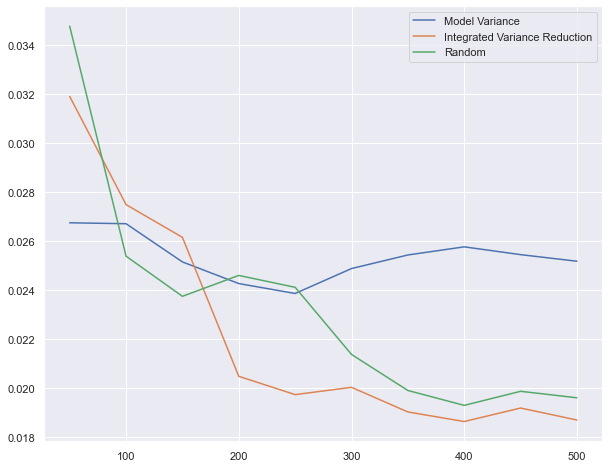

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [30]:
with open(f'experimental_design/models/ARD_model_variance_500_loops_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/models/ARD_integrated_variance_reduction_500_loops_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/models/random_GP_500_loops_timeloss.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)
        
with open(f'experimental_design/models/ARD_mses.pkl', 'wb') as f:
    pickle.dump((mses_MV, mses_IVR, mses_RND), f)